In [1]:
import os
import stat
import time
import re
import csv
import itertools
import pickle
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET

from scipy import cluster
from scipy.spatial.distance import squareform #for distance matrix conversion

from matplotlib import pyplot as plt

import tfold.utils.utils as utils
import tfold.utils.seq_tools as seq_tools
seq_tools.load_mhcs()

import tfold.utils.netmhc_tools as netmhc_tools
#import importlib
#importlib.reload(netmhc_tools)

aa_array=np.array(list('ACDEFGHIKLMNPQRSTVWXY'))

print(os.listdir('./data/pmhc_assays'))

MHC loading from MHC.pckl. To update the pickle file, set use_pickle to False
loaded 26122 MHC sequences in  1.5 s
MHC loading from MHC.pckl. To update the pickle file, set use_pickle to False
loaded 26122 MHC sequences in  1.5 s
['peptides_A2', 'iedb_ii_2009', 'iedb_i_2013', 'train_i.pckl', 'test_i.pckl', 'train_ii.pckl', 'netmhcpan_i41_ii40', 'iedb_pmhc_assays', 'test_ii.pckl', 'netmhc_predictions', 'train_clustered']


# IEDB pmhc assays

note: multi-file download from IEDB with aria2c, then unzip from the command line;
previously: single file download, unzip from mc, gave defective csv file 
(not sure whether unzip or download was the problem)

In [18]:
#merge multifile into single csv
mfdir='./data/pmhc_assays/iedb_pmhc_assays/multi_file'
t0=time.time()
lines=[]
for x in os.listdir(mfdir):
    with open(mfdir+'/'+x) as f:
        s=f.read().split('\n')
    lines+=[x for x in s if len(x)>0]
s='\n'.join(lines)
with open('./data/pmhc_assays/iedb_pmhc_assays/mhc_ligand_full_merged.csv','w') as f:
    f.write(s)
print('completed in ',time.time()-t0)
print('total lines:',len(lines))

completed in  91.09996056556702
total lines: 3939820


In [19]:
#print assays header
with open('./data/pmhc_assays/iedb_pmhc_assays/mhc_ligand_full_merged.csv') as f:
    f_csv=csv.reader(f)
    x=next(f_csv)
    y=next(f_csv)
    z=next(f_csv)
for i,a in enumerate(zip(x,y,z)):
    print('{:2d} {:25s} {:25s} {:25s}'.format(i,*a))
    
def load_assay_column(c,unique=True):    
    column=[]
    with open('./data/pmhc_assays/iedb_pmhc_assays/mhc_ligand_full_merged.csv') as f:
        f_csv=csv.reader(f)
        next(f_csv)
        next(f_csv)
        for line in f_csv:
            if len(line)>c:
                column.append(line[c])    
    if unique:
        return np.unique(column)
    else:
        return np.array(column)

 0 Reference                 Assay IRI                 http://www.iedb.org/assay/26
 1 Reference                 Reference IRI             http://www.iedb.org/reference/274
 2 Reference                 Type                      Literature               
 3 Reference                 PubMed ID                 15448372                 
 4 Reference                 Authors                   Yi-Hsiang Huang; Mi-Hua Tao; Cheng-Po Hu; Wan-Jr Syu; Jaw-Ching Wu
 5 Reference                 Journal                   J Gen Virol              
 6 Reference                 Date                      2004                     
 7 Reference                 Title                     Identification of novel HLA-A*0201-restricted CD8+ T-cell epitopes on hepatitis delta virus.
 8 Reference                 Submission ID                                      
 9 Epitope                   Epitope IRI               http://www.iedb.org/epitope/31803
10 Epitope                   Object Type               Linear p

## prepare MHCs for IEDB

In [20]:
#parse IEDB MHC notations
tree=ET.parse('./data/pmhc_assays/iedb_pmhc_assays/MhcAlleleNameList.xml')
root=tree.getroot()
mhc_list=[] #[DisplayedRestriction, Organism, OrganismNcbiTaxId, Class, Locus, Molecule, Chain1Name, Chain2Name]
for x in root:
    d={}
    for y in x:        
        d[y.tag]=y.text
    mhc_list.append([d['DisplayedRestriction'],d['Organism'],d['OrganismNcbiTaxId'],
                     d['Class'], d.setdefault('Locus',''),d.setdefault('Molecule',''),
                     d.setdefault('Chain1Name',''),d.setdefault('Chain2Name','')])    
mhc_list_df=pd.DataFrame(mhc_list,columns=['name','organism','organism_id','class','locus','molecule','chain1','chain2'])
print('total entries in mhc data:',len(mhc_list_df))

#load mhcs from assays
t0=time.time()    
mhc_alleles_u=load_assay_column(95)
print('completed in {}'.format(time.time()-t0))
print('unique alleles in assays:',len(mhc_alleles_u))

#restrict mhc data to mhcs used in assays
mhc_list_df=mhc_list_df[mhc_list_df['name'].isin(mhc_alleles_u)]
print('unique alleles in mhc data, restricted:',len(mhc_list_df))

total entries in mhc data: 22667
completed in 67.51644206047058
unique alleles in assays: 751
unique alleles in mhc data, restricted: 751


In [21]:
#functions for parsing mhc data

def parse_standard_chain(x):
    if x.count('-')==1 and x.count('*')==1:
        prefix,x=x.split('-')
        locus,allele=x.split('*')
        return prefix,locus,allele,''
    else:
        return None,None,None,'nonstandard chain'

def parse_rodent_chain(x,locus,cl):
    #x should start with 'H2-' or 'RT1-'
    #locus should follow in x after prefix
    #after locus and before chain assumed to be allele
    chain_dict={'alpha':'A','beta':'B'}    
    prefix,locus,allele=None,locus,None
    if x.startswith('H2-'):
        prefix='H2'
        x=x[3:]
    elif x.startswith('RT1-'):
        prefix='RT1'
        x=x[4:]
    else:        
        return prefix,locus,allele,'not rodent'
    if cl=='II':
        x,chain=x.split()
        chain=chain_dict[chain]
    elif cl=='I':
        chain=''
    else:
        return prefix,locus,allele,'rodent mhc class not recognized'
    if x.startswith(locus):
        allele=x[len(locus):]
        locus=locus+chain
        return prefix,locus,allele,''
    else:
        return prefix,locus,allele,'rodent locus not recognized'          

def process_mutants(x,cl):
    mut=['','']    
    if 'mutant' in x:
        if x=='HLA-B*27:05 D74Y D77N mutant':  #fix a typo
            x='HLA-B*27:05 D74Y, D77N mutant'
        if cl=='II':
            if '/' in x:
                xa,xb=x.split('/')
                if 'mutant' in xa:
                    x=xa
                    chain=0 #A
                else:
                    x=xb
                    chain=1 #B
            else:
                if re.match('^HLA-D[P,Q,R]B',x):
                    chain=1
                else:
                    return mut,'cl II mutant chain undefined'
        else:
            chain=0
        x=re.sub(', ',',',x)
        xx=x.split()
        if xx[-1]!='mutant':
            return mut,'mutant parsing error'
        mut[chain]=xx[-2]
    else:
        pass    
    return mut,''     

def parse_mhc_record(y):
    '''
    returns [species, species_id, species_prefix, class, locus_A, allele_A, mut_A, locus_B, allele_B, mut_B], error    
    '''            
    x=y['name']
    cl=y['class']
    locus=y['locus']
    species=y['organism']
    species_id=y['organism_id']
    ch1=y['chain1']
    ch2=y['chain2']
    error=''
    species_prefix, locus_A, allele_A, locus_B, allele_B=None,locus,None,locus,None
    
    #set class to 'I' for non-classical HLA-E,F,G
    if x.startswith(('HLA-E','HLA-F','HLA-G')):
        cl='I'         
    
    #parse mutations, if any
    mut,error_mut=process_mutants(x,cl)
    error+=error_mut
    
    #parse when chain info present
    if cl=='I':
        if ch1:     
            locus_B,allele_B='b2m',''
            species_prefix,locus_A,allele_A,error_A=parse_standard_chain(ch1)
            if error_A:
                species_prefix,locus_A,allele_A,error_A=parse_rodent_chain(ch1,locus,cl)           
            if error_A:
                error='cannot parse chain A; '            
        else:
            error+='chain info missing; '
    elif cl=='II':
        if ch1 and ch2:
            if ch1.endswith('DRA'): #impute DRA allele 01:01, assuming low variability, esp. in antigen-binding region
                ch1+='*01:01'
            species_prefix,locus_A,allele_A,error_A=parse_standard_chain(ch1)
            if error_A:
                species_prefix,locus_A,allele_A,error_A=parse_rodent_chain(ch1,locus,cl)             
            if error_A:
                error+='cannot parse chain A; '
            species_prefix,locus_B,allele_B,error_B=parse_standard_chain(ch2)
            if error_B:
                species_prefix,locus_B,allele_B,error_B=parse_rodent_chain(ch2,locus,cl)               
            if error_B:
                error+='cannot parse chain B; '            
        else:
            error+='chain info missing; '
    else:
        error+='non-classical; '    
    return [species, species_id, species_prefix, cl, locus_A, allele_A, mut[0], locus_B, allele_B, mut[1]], error

In [24]:
# keep errors here
bad_mhcs=[] #[key,error]

In [25]:
#do parsing

results=[]
errors=[]
bad_mhcs=[]
n_good=0
n_bad=0
for x in mhc_list_df.iterrows():
    x=x[1]
    result,error=parse_mhc_record(x)
    result=[x['name']]+result
    if error:        
        errors.append(error)
        bad_mhcs.append([x['name'],error])
        n_bad+=1
    else:
        results.append(result)
        n_good+=1
results_df=pd.DataFrame(np.array(results),columns=['name','species','species_id','species_prefix','class',
                                                   'locus_A','allele_A','mut_A','locus_B','allele_B','mut_B'])
errors=np.array(errors)
print('good {}, bad {}'.format(n_good,n_bad))
for x in np.unique(errors):    #errors summary
    print(x,np.sum(errors==x))
    
#save results
#results_df.to_pickle('./data/pmhc_assays/iedb_pmhc_assays/mhc_data_summary.pckl')   #no point in saving

#before multi-file
#464 196
#23, 4, 142, 3, 24

#after multi-file
#545 206
#23, 4, 151, 3, 25

good 545, bad 206
cannot parse chain A;  23
cannot parse chain B;  4
chain info missing;  151
cl II mutant chain undefined 3
non-classical;  25


In [26]:
# find alleles, do mutations
def transform_mutations(m):
    return ['|'.join([x[0],x[1:-1],x[-1]]) for x in m.split(',')]

errors_before=len(bad_mhcs)
mhcs_dict={}
species_missing=[]
for x in results_df.iterrows():
    x=x[1]
    k=x['species_id'],x['locus_A'],x['allele_A']
    if x['species_id'] not in seq_tools.mhcs_df['species_id'].values:
        species_missing.append(x['species_id'])
        bad_mhcs.append([x['name'],'species missing'])
        continue
    if k in seq_tools.mhcs:
        mhc_A=seq_tools.mhcs[k]
        if x['mut_A']:
            if ':' in x['mut_A']: #'B:I66A' for B*08:01; is it mutation in B2M?
                bad_mhcs.append([x['name'],'mut A error: unrecognized symbol'])
                continue
            m=transform_mutations(x['mut_A'])
            mhc_A,mut_err=mhc_A.mutate(m,0)
            if mut_err:
                bad_mhcs.append([x['name'],'mut A error:'+mut_err])
                continue
        mhc_A=mhc_A.dump()
    else:
        bad_mhcs.append([x['name'],'chain A seq missing'])
        continue
    if x['class']=='II':
        k=x['species_id'],x['locus_B'],x['allele_B']
        if k in seq_tools.mhcs:
            mhc_B=seq_tools.mhcs[k]
            if x['mut_B']:
                m=transform_mutations(x['mut_B'])
                mhc_B,mut_err=mhc_B.mutate(m,0)
                if mut_err:
                    bad_mhcs.append([x['name'],'mut B error:'+mut_err])
                    continue
            mhc_B=mhc_B.dump()
        else:
            bad_mhcs.append([x['name'],'chain B seq missing'])
            continue
    else:
        mhc_B=None
    mhcs_dict[x['name']]=[mhc_A,mhc_B]
errors_new=len(bad_mhcs)-errors_before
print('mhcs identified:',len(mhcs_dict))
print('mhcs missing:',errors_new)
print('species missing:',len(species_missing))
print(set(species_missing))

#save dict {mhc_iedb_name: [{data_A,info_A}, None or {data_B,info_B}]}
with open('./data/pmhc_assays/iedb_pmhc_assays/iedb_mhc_dict.pckl','wb') as f:
    pickle.dump(mhcs_dict,f)
    
#before multi-file
#412
#52
#5 {'8839', '9685', '9986', '9402'}

#after multi-file
#490
#55
#7 {'9986', '9685', '9337', '9402', '8839'}

mhcs identified: 490
mhcs missing: 55
species missing: 7
{'9986', '9685', '9337', '9402', '8839'}


In [27]:
#check errors
bad_mhcs=np.array(bad_mhcs)
utils.print_hist(bad_mhcs[:,1])

cannot parse chain A;             23
cannot parse chain B;              4
chain A seq missing               36
chain B seq missing                2
chain info missing;              151
cl II mutant chain undefined       3
mut A error: unrecognized symbol   1
mut B error:C|30|S|0;              1
mut B error:D|57|A|0;              1
mut B error:D|57|A|0;Y|60|H|0;     1
mut B error:D|57|V|0;              1
mut B error:D|57|V|0;Y|60|S|0;     1
mut B error:G|86|Y|0;              1
mut B error:N|82|A|0;              1
mut B error:Q|74|R|0;              2
non-classical;                    25
species missing                    7


In [28]:
#count assays dropped due to missing mhc
mhcs_in_assays=load_assay_column(95,unique=False)
print('total assays:',len(mhcs_in_assays))
n_good=0
bad_dict={}
for x in mhcs_in_assays:
    if x in mhcs_dict:
        n_good+=1
    else:
        k=bad_mhcs[bad_mhcs[:,0]==x][0,1]
        bad_dict.setdefault(k,0)
        bad_dict[k]+=1
print('assays with recognized mhc:',n_good)
print('unrecognized mhcs and numbers of dropped assays:')
for k,v in bad_dict.items():
    print('{:25s} {:6d}'.format(k,v))
    
#most likely dropped due to things like 'HLA class I' or 'HLA-A2', i.e. unresolved allele

#before multi-file
#1731608, 1109469 (chain info missing  608986)
#after multi-file
#3939818, 2269757 (chain info missing 1648349)

total assays: 3939818
assays with recognized mhc: 2269757
unrecognized mhcs and numbers of dropped assays:
chain info missing;       1648349
non-classical;              1846
chain A seq missing         5536
cannot parse chain A;       7012
cl II mutant chain undefined     60
chain B seq missing           27
mut B error:D|57|A|0;         21
mut B error:D|57|A|0;Y|60|H|0;     21
mut B error:D|57|V|0;         21
mut B error:D|57|V|0;Y|60|S|0;     21
mut B error:G|86|Y|0;          3
mut A error: unrecognized symbol      2
cannot parse chain B;        360
mut B error:C|30|S|0;        888
mut B error:Q|74|R|0;         52
species missing             5839
mut B error:N|82|A|0;          3


## prepare IEDB assays

In [85]:
#load processed mhcs
with open('./data/pmhc_assays/iedb_pmhc_assays/iedb_mhc_dict.pckl','rb') as f:
    mhcs_dict=pickle.load(f)
print(len(mhcs_dict))
x=mhcs_dict['HLA-B*08:01 N80I mutant']
print(x[0].keys())
#print(x[0]['data'])
print(x[0]['info'])
#412->490

490
dict_keys(['data', 'info'])
{'species': '9606', 'class': 'I', 'chain': 'A', 'locus': 'B', 'allele': '08:01', 'gaps': array([],
      dtype=[('seq', '<U3'), ('num', '<i2'), ('ins', '<U1'), ('pdbnum', '<U5'), ('ss', '<U15'), ('mutations', '<U3')])}


In [86]:
#read assays and reduce columns
#keep only linear antigens, canonical aa, resolved mhc

aa_set=set(list('ACDEFGHIKLMNPQRSTVWY'))
assays=[]
n=0
t0=time.time()
with open(f'./data/pmhc_assays/iedb_pmhc_assays/mhc_ligand_full_merged.csv') as f:
    f_csv=csv.reader(f)
    next(f_csv)
    next(f_csv)
    for line in f_csv:
        if len(line)>=96:
            n+=1
            antigen_type=line[10]
            pep=line[11]
            mhc=line[95]
            ref_date=line[6]
            a_method=line[79]
            a_group=line[80]        
            a_qual=line[83]
            a_units=line[81]
            a_quant_ineq=line[84]
            a_quant_value=line[85]
            if (antigen_type=='Linear peptide') and not (set(list(pep))-aa_set) and (mhc in mhcs_dict):
                mhc1=mhcs_dict[mhc]               
                m=mhc1[0]['info']
                cl,species,locus,allele=m['class'],m['species'],m['locus'],m['allele']
                n_mut=np.sum(mhc1[0]['data']['mutations']!='')
                if cl=='II':
                    m=mhc1[1]['info']
                    species_B,locus_B,allele_B=m['species'],m['locus'],m['allele']
                    n_mut+=np.sum(mhc1[1]['data']['mutations']!='')
                else:
                    species_B,locus_B,allele_B=None,None,None                    
                assays.append([pep,mhc,cl,(species,locus,allele),(species_B,locus_B,allele_B),n_mut,
                               ref_date,a_method,a_group,a_qual,a_units,a_quant_ineq,a_quant_value])
        else: #short lines means defective file. Fixed
            print(n,fname,line)
print('completed in ',time.time()-t0)
print('total saved: {} of {}'.format(len(assays),n))
assays=pd.DataFrame(assays,columns=['pep','mhc_iedb','class','mhc_a','mhc_b','n_mutations',
                                    'date','method','group','qual','units','quant_ineq','quant_value'])
assays['quant_value']=pd.to_numeric(assays['quant_value']) #str to float
assays.to_pickle('./data/pmhc_assays/iedb_pmhc_assays/assays.pckl')

#   2157321 of 3939806
#-> 2179615 of 3939818 (multi-file, mhc properly restricted)

completed in  139.4083800315857
total saved: 2179615 of 3939818


In [87]:
assays=pd.read_pickle('./data/pmhc_assays/iedb_pmhc_assays/assays.pckl')
print(assays.columns)
print()
print('group:')
print(assays['group'].value_counts())
print()
print('method:')
print(assays['method'].value_counts())
print()
print('qual:')
print(assays['qual'].value_counts())
print()
print('class:')
print(assays['class'].value_counts())
print()
print('mutations:',np.sum(assays['n_mutations']>0))

Index(['pep', 'mhc_iedb', 'class', 'mhc_a', 'mhc_b', 'n_mutations', 'date',
       'method', 'group', 'qual', 'units', 'quant_ineq', 'quant_value'],
      dtype='object')

group:
ligand presentation                             1468258
qualitative binding                              468196
dissociation constant KD (~IC50)                  86456
half maximal inhibitory concentration (IC50)      66799
dissociation constant KD (~EC50)                  56631
dissociation constant KD                          18937
half life                                         11009
half maximal effective concentration (EC50)        1532
3D structure                                       1015
50% dissociation temperature                        685
off rate                                             65
on rate                                              32
Name: group, dtype: int64

method:
cellular MHC/mass spectrometry            1193607
purified MHC/direct/fluorescence           504579
mass spectrome

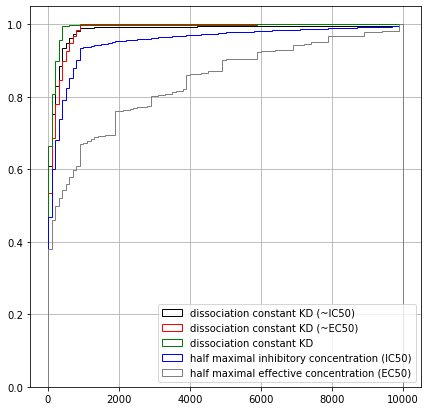

In [88]:
#assay groups for Kd: check calibration
assays_pos=assays[assays['qual'].isin(('Positive','Positive-High','Positive-Intermediate'))]
#lim0,lim1=1,5e4
lim0,lim1=1,1e4
n=100
colors=['black','red','green','blue','gray']
delta=(lim1-lim0)/n
bins=np.arange(lim0,lim1+delta,delta)
plt.figure(figsize=(7,7))
groups=['dissociation constant KD (~IC50)','dissociation constant KD (~EC50)','dissociation constant KD',
        'half maximal inhibitory concentration (IC50)','half maximal effective concentration (EC50)']
for i,g in enumerate(groups):
    series=assays_pos[assays_pos['group']==g]['quant_value']    
    plt.hist(series,bins=bins,histtype='step',cumulative=1,density=True,color=colors[i])    
plt.legend(groups,loc='lower right')
plt.grid()
plt.show()
#conclusion: things with 'KD' in the title are fine, the other two are not

## Kd assays

assays with Kd, merged by geometric mean, with minimal date assigned

save as `assays_Kd.pckl`

In [93]:
assays=pd.read_pickle('./data/pmhc_assays/iedb_pmhc_assays/assays.pckl')
#Kd assay groups

#three groups (better choice)
#groups=['dissociation constant KD (~IC50)','dissociation constant KD (~EC50)','dissociation constant KD']

#five groups
groups=['dissociation constant KD (~IC50)','dissociation constant KD (~EC50)','dissociation constant KD',
        'half maximal inhibitory concentration (IC50)','half maximal effective concentration (EC50)']

assays_kd=assays[assays['group'].isin(groups)]
assays_kd=assays_kd.drop(['method','group'],axis=1)
#check units, ineq, qual
print('units:')
print(assays_kd['units'].value_counts())
print()
print('ineq:')
print(assays_kd['quant_ineq'].value_counts())
print()
print('qual:')
print(assays_kd['qual'].value_counts())

units:
nM    230355
Name: units, dtype: int64

ineq:
      113627
>      58242
=      56676
<       1510
>=       257
<=        43
Name: quant_ineq, dtype: int64

qual:
Negative                 92971
Positive-Low             46696
Positive-High            44808
Positive-Intermediate    40514
Positive                  5366
Name: qual, dtype: int64


In [94]:
t0=time.time()
df=assays_kd.copy()
print(len(df))
#filter uninformative inequalities, drop quant_ineq
df=df[(df['quant_ineq'].isin(['>','>='])&(df['quant_value']>=20000.))|
      (df['quant_ineq'].isin(['<','<='])&(df['quant_value']<=100.))|
      (df['quant_ineq'].isin(['','=']))]
print(len(df))
#set Kd to cutoff for Negative with Kd nan
df.loc[df['quant_value'].isna()&(df['qual']=='Negative'),'quant_value']=50000.
df['kd']=df['quant_value']
df=df.drop(['quant_ineq','units','qual','quant_value'],axis=1)

#take geometric mean on Kds
df_kd=df.copy()
df_kd['kd']=np.log(df_kd['kd'])
df_kd=df_kd.groupby(['pep','mhc_iedb'])['kd'].mean().reset_index()
df_kd['kd']=np.exp(df_kd['kd'])
#take min dates
df_date=df.copy()
df_date=df.groupby(['pep','mhc_iedb'])['date'].min().reset_index()
#merge
df=df.drop(['date','kd'],axis=1).drop_duplicates()
df=df.merge(df_date,on=['pep','mhc_iedb'])
df=df.merge(df_kd,on=['pep','mhc_iedb'])

print(len(df))
print('completed in',time.time()-t0)

print('with mutations:',np.sum(df['n_mutations']>0))
#for three groups: only 7 pmhcs with mutations => drop for simplicity
#for five groups: 9 with mutations (keep for completeness)
if len(groups)==3: #use for three groups
    df=df[df['n_mutations']==0]
    df=df.drop('n_mutations',axis=1)
    print('with mutations dropped:',len(df))
    df.to_pickle('./data/pmhc_assays/iedb_pmhc_assays/assays_Kd.pckl') #only keep three BA groups with Kd
elif len(groups)==5:
    df.to_pickle('./data/pmhc_assays/iedb_pmhc_assays/assays_Kd5.pckl') #keep all five BA groups
else:
    print(groups)

230355
220404
195053
completed in 27.804668188095093
with mutations: 9


In [92]:
df=pd.read_pickle('./data/pmhc_assays/iedb_pmhc_assays/assays_Kd.pckl')
print('cl I:',np.sum(df['class']=='I'),'cl II:',np.sum(df['class']=='II'))

cl I: 112766 cl II: 36001


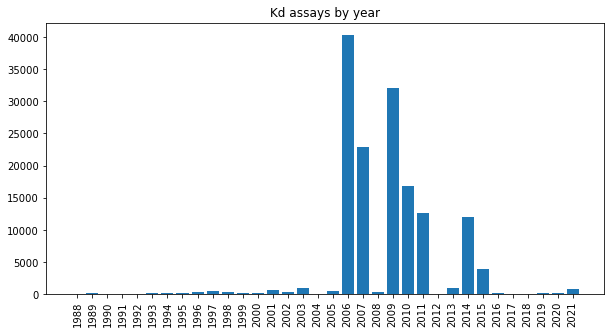

In [118]:
#histogram by date
x=df['date'].value_counts()
years=x.index.values
numbers=x.values
ind=np.argsort(years)
years,numbers=years[ind],numbers[ind]
xx=np.arange(len(years))
plt.figure(figsize=(10,5))
plt.bar(xx,numbers)
plt.xticks(xx,years,rotation='vertical')
plt.title('Kd assays by year')
plt.show()

In [119]:
#histogram by Kd
for limit in [50,100,500,1000,5000]:
    print('{:5d}'.format(limit), len(df[df['kd']<limit]))
print('out of',len(df))

   50 27076
  100 34498
  500 53290
 1000 62204
 5000 80657
out of 148767


In [120]:
#by mhc
print(df['mhc_iedb'].value_counts().head(50))

HLA-A*02:01       8147
HLA-DRB1*01:01    5940
HLA-A*03:01       5381
HLA-A*11:01       4606
HLA-A*31:01       4464
HLA-A*68:02       3895
HLA-A*02:03       3764
HLA-A*01:01       3253
HLA-B*15:01       3198
HLA-A*02:06       3195
HLA-A*26:01       3140
HLA-B*07:02       2817
HLA-A*68:01       2757
HLA-A*33:01       2739
HLA-A*02:02       2555
HLA-B*40:01       2343
HLA-A*69:01       2301
HLA-B*58:01       2273
HLA-B*57:01       2161
Mamu-A1*001:01    2142
HLA-B*18:01       2084
HLA-B*51:01       2076
H2-Kb             1957
HLA-B*08:01       1952
HLA-A*29:02       1782
HLA-B*27:05       1749
H2-Db             1682
HLA-A*23:01       1672
HLA-B*46:01       1661
HLA-B*44:02       1633
HLA-A*24:02       1582
HLA-B*15:17       1405
HLA-B*35:01       1399
HLA-B*39:01       1290
HLA-DRB1*04:01    1279
HLA-A*30:01       1274
HLA-A*30:02       1176
HLA-A*24:03       1132
HLA-DRB1*07:01    1125
HLA-DRB1*15:01    1111
HLA-A*80:01       1105
HLA-DRB1*11:01    1097
HLA-DRB1*03:01    1093
HLA-DRB1*13

## assays merged by qual

all assays merged by qual (according to some chosen numerical scores), with minimal dates assigned

save as `assays_qual.pckl`

In [121]:
assays=pd.read_pickle('./data/pmhc_assays/iedb_pmhc_assays/assays.pckl')
print('total:',len(assays))
print('qual:')
print(assays['qual'].value_counts())
print('with mutations:',np.sum(assays['n_mutations']>0))

total: 2179615
qual:
Positive                 1476489
Negative                  558384
Positive-High              50822
Positive-Low               50421
Positive-Intermediate      43499
Name: qual, dtype: int64
with mutations: 14792


In [122]:
#merge qual scores

qual_scores={'Negative':-1.,'Positive-Low':0.5,'Positive-Intermediate':1.,'Positive-High':2.,'Positive':1.}
assays['qual_score']=assays['qual'].map(qual_scores)

#assays=assays.sample(10000)

t0=time.time()
#take mean scores
df_score=assays.groupby(['pep','mhc_iedb'])['qual_score'].mean().reset_index()
#take min dates
df_date=assays.groupby(['pep','mhc_iedb'])['date'].min().reset_index()
#merge
df=assays.drop(['date','method','group','qual','qual_score','units','quant_ineq','quant_value'],axis=1)
df=df.drop_duplicates()
df=df.merge(df_date,on=['pep','mhc_iedb'])
df=df.merge(df_score,on=['pep','mhc_iedb'])
print('completed in',time.time()-t0)
print('total merged:',len(df))
df.to_pickle('./data/pmhc_assays/iedb_pmhc_assays/assays_qual.pckl')

completed in 198.40239024162292
total merged: 1473774


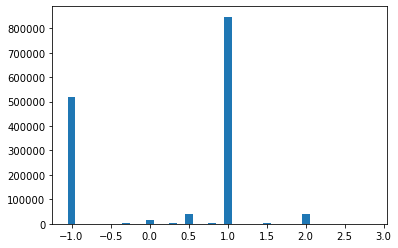

In [128]:
#qual score distribution
plt.figure()
bins=-0.05+np.arange(-1,3,0.1)
plt.hist(df['qual_score'],bins=bins)
plt.show()

## time assays

In [143]:
assays=pd.read_pickle('./data/pmhc_assays/iedb_pmhc_assays/assays.pckl')
assays_t=assays[assays['group'].isin(['half life'])]
#check units, ineq, qual
print('units:')
print(assays_t['units'].value_counts())
print()
print('ineq:')
print(assays_t['quant_ineq'].value_counts())
print()
print('qual:')
print(assays_t['qual'].value_counts())

print('mutations:',np.sum(assays_t['n_mutations']>0))
#just 12 mutations => drop for simplicity
assays_t=assays_t[assays_t['n_mutations']==0]
assays_t=assays_t.drop('n_mutations',axis=1)

#for simplicity, drop data with inequalities; they are only 1.4% of the total
assays_t=assays_t[assays_t['quant_ineq'].isin(['=',''])]
print(len(assays_t))

#drop where time is nan
assays_t=assays_t[~assays_t['quant_value'].isna()]
print('final:',len(assays_t))

units:
min    11009
Name: units, dtype: int64

ineq:
=     6982
      3872
>      102
<       49
>=       4
Name: quant_ineq, dtype: int64

qual:
Positive                 3665
Positive-High            2575
Positive-Intermediate    1891
Positive-Low             1741
Negative                 1137
Name: qual, dtype: int64
mutations: 12
10843
final: 10695


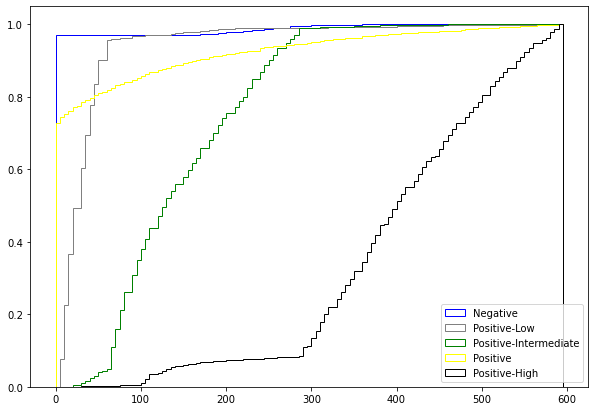

In [144]:
#get an idea of qual-quant correspondence
quals=['Negative','Positive-Low','Positive-Intermediate','Positive','Positive-High']#assays_t['qual'].unique()
colors=['blue','gray','green','yellow','black']
plt.figure(figsize=(10,7))
bins=np.arange(0,600,5)
for i,q in enumerate(quals):
    plt.hist(assays_t[assays_t['qual']==q]['quant_value'],bins=bins,histtype='step',color=colors[i],density=True,cumulative=1)
plt.legend(quals,loc='lower right')
plt.show()

In [145]:
t0=time.time()
print('before merging:',len(assays_t))
#take mean scores
df_score=assays_t.groupby(['pep','mhc_iedb'])['quant_value'].mean().reset_index()
#take min dates
df_date=assays_t.groupby(['pep','mhc_iedb'])['date'].min().reset_index()
#merge
df=assays_t.drop(['quant_value','date','method','group','qual','units','quant_ineq'],axis=1)
df=df.drop_duplicates()
df=df.merge(df_date,on=['pep','mhc_iedb'])
df=df.merge(df_score,on=['pep','mhc_iedb'])
print('completed in',time.time()-t0)
print('total merged:',len(df))
df.to_pickle('./data/pmhc_assays/iedb_pmhc_assays/assays_time.pckl')

before merging: 10695
completed in 1.3867995738983154
total merged: 10404


In [147]:
#by class
print(df['class'].value_counts())

I     10067
II      337
Name: class, dtype: int64


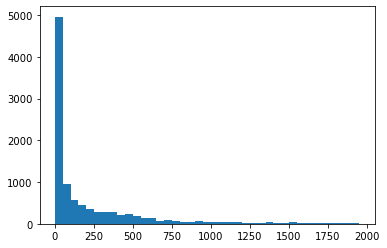

above upper limit: 411 (0.0395040369088812)


In [148]:
#time distribution in the output
plt.figure()
bins=np.arange(0,2000,50)
plt.hist(df['quant_value'],bins=bins)
plt.show()
n_above=np.sum(df['quant_value']>bins[-1])
n_total=len(df)
print(f'above upper limit: {n_above} ({n_above/n_total})')

## length distribution

In [3]:
with open('./data/pmhc_assays/iedb_pmhc_assays/assays.pckl','rb') as f:
    assays=pickle.load(f)
print(len(assays))

2179615


In [13]:
df=assays[assays['method']=='cellular MHC/mass spectrometry']
print(len(df))

1193607


cl I 8 to 12: 0.938
cl II 12 to 20: 0.932


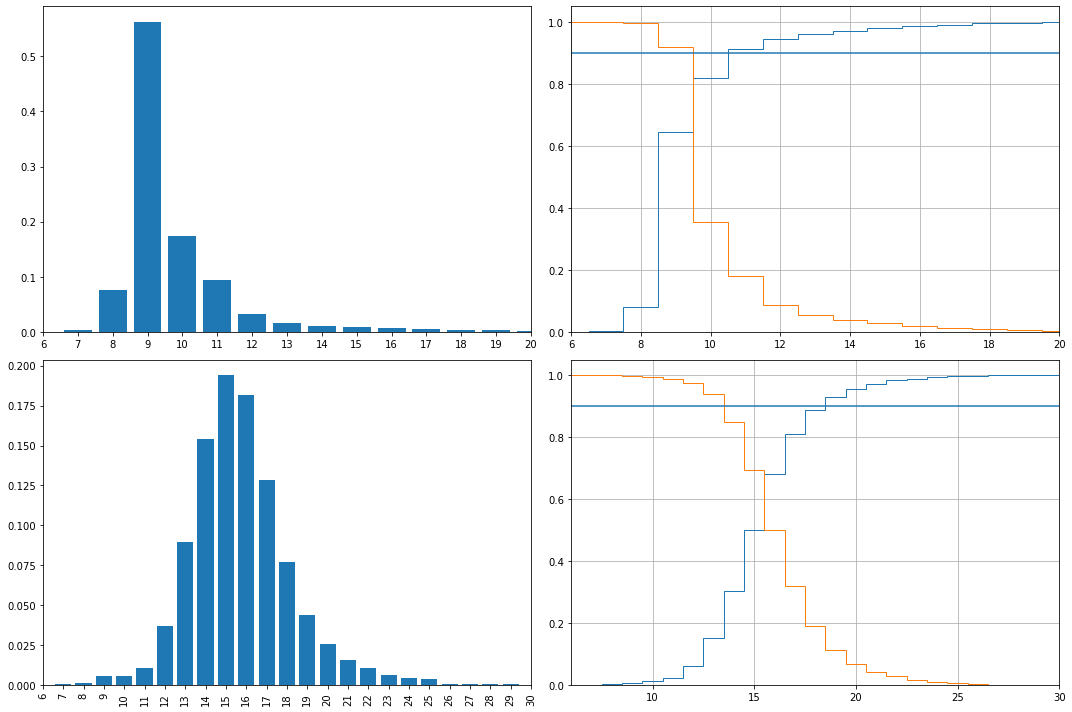

In [37]:
lim1=[6,20]
bins1=np.arange(xlim1[0],xlim1[1]+2)-0.5
lim2=[6,30]
bins2=np.arange(xlim2[0],xlim2[1]+2)-0.5
plt.figure(figsize=(15,10))
plt.subplot(221)
x=df[df['class']=='I']['pep'].map(len)
lmin,lmax=8,12
print('cl I {:d} to {:d}: {:5.3f}'.format(lmin,lmax,np.sum((x>=lmin)&(x<=lmax))/len(x)))
xu=np.sort(x.unique())
plt.bar(xu,np.array([np.sum(x==a) for a in xu])/len(x))
plt.xticks(xu)
plt.xlim(*lim1)
plt.subplot(222)
plt.grid()
plt.hist(x,histtype='step',cumulative=1,bins=bins1,density=True)
plt.hist(x,histtype='step',cumulative=-1,bins=bins1,density=True)
plt.axhline(0.9)
plt.xlim(*lim1)
plt.subplot(223)
x=df[df['class']=='II']['pep'].map(len)
lmin,lmax=12,20
print('cl II {:d} to {:d}: {:5.3f}'.format(lmin,lmax,np.sum((x>=lmin)&(x<=lmax))/len(x)))
xu=np.sort(x.unique())
plt.bar(xu,np.array([np.sum(x==a) for a in xu])/len(x))
plt.xticks(xu,rotation=90)
plt.xlim(*lim2)
plt.subplot(224)
plt.grid()
plt.hist(x,histtype='step',cumulative=1,bins=bins2,density=True)
plt.hist(x,histtype='step',cumulative=-1,bins=bins2,density=True)
plt.axhline(0.9)
plt.xlim(*lim2)
plt.tight_layout()
plt.show()

# IEDB 2013 cl I

`http://tools.iedb.org/main/datasets/`<br>
`http://tools.iedb.org/mhci/download/`

"Dataset used for retraining the IEDB class I binding prediction tools" from `http://tools.iedb.org/mhci/download/`:   "Description of the dataset: The dataset is largely identical to that of Kim et al (2014), described above, but includes additional data that was not publicly available at the time. Date of the dataset generation: 2013.
Details on the dataset generation: The dataset was compiled from three sources: the IEDB, the Sette lab, and the Buus lab. If a peptide/allele combination had more than 1 measurement among the three sources, its geometric mean was taken.

In [3]:
with open('./data/pmhc_assays/iedb_pmhc_assays/iedb_mhc_dict.pckl','rb') as f:
    mhcs_dict=pickle.load(f)
sdict={'Mamu':'9544','SLA':'9823','Patr':'9598','Gogo':'9593','BoLA':'9913','RT1':'10116'}
def convert_iedb_extra_mhc1(x):        
    if x.startswith('H-2'):
        species,locus,allele='10090',x[4],x[5:]
    else:
        try:
            species,x=x.split('-')
            species=sdict[species]
            locus,allele=x.split('*')
            if len(allele)>2:
                allele=allele[:2]+':'+allele[2:]
            else:
                allele+=':01'
        except Exception:
            species,locus,allele=None,None,None
    return species,locus,allele

with open('./data/pmhc_assays/iedb_i_2013/bdata.20130222.mhci.txt') as f:
    s=f.read().split('\n')

iedb_extra=[]
bad_mhc=[]
for line in s[1:]:
    if len(line)>0:
        line=line.split()
        mhc=line[1]
        if mhc in mhcs_dict:
            x=mhcs_dict[mhc][0]['info']
            line[1]=x['species'],x['locus'],x['allele']
        else:
            x=convert_iedb_extra_mhc1(mhc)
            if x in seq_tools.mhcs:
                line[1]=x
            else:
                bad_mhc.append(line)
                continue        
        iedb_extra.append(line)
iedb_extra=pd.DataFrame(iedb_extra,columns=['species','mhc','len','pep','ineq','kd'])
iedb_extra['kd']=pd.to_numeric(iedb_extra['kd'])
iedb_extra=iedb_extra[['pep','mhc','ineq','kd']]
bad_mhc=np.array(bad_mhc)
print('total assays loaded:',len(iedb_extra))
print('dropped because of bad mhc:',len(bad_mhc))
utils.print_hist(bad_mhc[:,1])

total assays loaded: 170433
dropped because of bad mhc: 16251
BoLA-AW10    167
BoLA-D18.4   259
BoLA-HD6     268
BoLA-JSP.1   160
BoLA-T2C      90
BoLA-T2a     167
BoLA-T2b     157
ELA-A1        14
Gogo-B*0101   15
H-2-Kbm8       2
HLA-A1         1
HLA-A11       74
HLA-A2        63
HLA-A24        2
HLA-A26        4
HLA-A3         6
HLA-A3/11      2
HLA-B27        2
HLA-B44        5
HLA-B51        3
HLA-B60        5
HLA-B7        67
HLA-B8         1
HLA-Cw1        4
HLA-Cw4        2
Mamu-A*01   2590
Mamu-A*02   1358
Mamu-A*07    681
Mamu-A*11   1261
Mamu-A*2201  689
Mamu-A*2601  206
Mamu-B*01    880
Mamu-B*03   1136
Mamu-B*04      2
Mamu-B*08   1127
Mamu-B*1001  159
Mamu-B*17   1650
Mamu-B*3901  459
Mamu-B*52    894
Mamu-B*6601  101
Mamu-B*8301  432
Mamu-B*8701  155
Patr-B*0101  784
Patr-B*0901    1
RT1-Bl         7
RT1A         139


In [4]:
t0=time.time()
df=iedb_extra.copy()
print(len(df))
#filter uninformative inequalities
df=df[(df['ineq'].isin(['>','>='])&(df['kd']>=20000.))|
      (df['ineq'].isin(['<','<='])&(df['kd']<=100.))|
      (df['ineq'].isin(['','=']))]
print(len(df))
df=df.drop(['ineq'],axis=1)

#take geometric mean on Kds
df_kd=df.copy()
df_kd['kd']=np.log(df_kd['kd'])
df_kd=df_kd.groupby(['pep','mhc'])['kd'].mean().reset_index()
df_kd['kd']=np.exp(df_kd['kd'])
#merge
df=df.drop(['kd'],axis=1).drop_duplicates()
df=df.merge(df_kd,on=['pep','mhc'])
print(len(df))
print('completed in',time.time()-t0)

df.to_pickle('./data/pmhc_assays/iedb_i_2013/assays.pckl')

170433
165196
165196
completed in 0.32720398902893066


# IEDB 2009 cl II

In [37]:
def convert_netmhc_mhc2(x):
    if x.startswith('HLA-DRB'):
        locus_b,allele_b=x[4:].split('*')
        allele_b=allele_b[:2]+':'+allele_b[2:]
        return ('9606','DRA','01:01'),('9606',locus_b,allele_b)
    elif x.startswith('HLA'):
        xa,xb=x[4:].split('/')
        if xa=='DPA1*01':  
            xa+='03'      #this is not a great guess: there are many alleles differing in digits 3-4, with dif. seq
        locus_a,allele_a=xa.split('*')        
        locus_b,allele_b=xb.split('*')        
        allele_a=allele_a[:2]+':'+allele_a[2:]
        allele_b=allele_b[:2]+':'+allele_b[2:]
        return ('9606',locus_a,allele_a),('9606',locus_b,allele_b)
    elif x.startswith('H-2'):
        locus=x[4:6]
        allele=x[6:]
        return ('10090',locus+'A',allele),('10090',locus+'B',allele)
    else:
        return None,None    

In [42]:
cdir='./data/pmhc_assays/iedb_ii_2009/class_II_all_split_5cv'
assays=[]
bad_mhcs=[]
for x in os.listdir(cdir):
    with open(cdir+'/'+x) as f:
        lines=f.read().split('\n')
        for l in lines:
            if len(l)>0:
                _1,mhc,_2,_3,pep,ineq,kd=l.split('\t')
                mhc_a,mhc_b=convert_netmhc_mhc2(mhc)
                if (mhc_a in seq_tools.mhcs) and (mhc_a in seq_tools.mhcs):
                    assays.append([pep,mhc_a,mhc_b,ineq,kd])   
                else:
                    bad_mhcs.append(mhc)
print(len(assays))
iedb=pd.DataFrame(assays,columns=['pep','mhc_a','mhc_b','ineq','kd'])
iedb=iedb.drop_duplicates()
iedb['kd']=pd.to_numeric(iedb['kd'])
print(len(iedb))
print('bad mhcs',len(bad_mhcs))

229775
45816
bad mhcs 0


In [51]:
df=iedb.copy()

#filter uninformative inequalities, drop quant_ineq
df=df[(df['ineq'].isin(['>','>='])&(df['kd']>=20000.))|
      (df['ineq'].isin(['<','<='])&(df['kd']<=100.))|
      (df['ineq'].isin(['','=']))]
df=df.drop(['ineq'],axis=1)
print(len(df))
#set Kd to cutoff for Negative with Kd nan
#df.loc[df['quant_value'].isna()&(df['qual']=='Negative'),'quant_value']=50000.
#df=df.drop(['quant_ineq','units','qual'],axis=1)
#take geometric mean on Kds
df_kd=df.copy()
df_kd['kd']=np.log(df_kd['kd'])
df_kd=df_kd.groupby(['pep','mhc_a','mhc_b'])['kd'].mean().reset_index()
df_kd['kd']=np.exp(df_kd['kd'])
#merge
df=df.drop(['kd'],axis=1).drop_duplicates()
df=df.merge(df_kd,on=['pep','mhc_a','mhc_b'])
#save
df.to_pickle('./data/pmhc_assays/iedb_ii_2009/assays.pckl')

45806


# netMHCpan 4.1 training data

source: `https://services.healthtech.dtu.dk/suppl/immunology/NAR_NetMHCpan_NetMHCIIpan/`
        
(see also `http://tools.iedb.org/main/datasets/`)        

According to the supplementary info, "BA data was gathered from Alvarez. et al (2) and the IEDB (5)". Alvarez reference is the NNAlign_MA paper which says "HLA class I: SA data - both binding affinity (BA), and MS MHC
eluted ligands (EL) - was extracted from Jurtz et al. (14)." Jurtz is the netMHCpan 4.0 paper. There is no information about the source of BA data anywhere in that paper or in any suppl. materials. But IEDB (`http://tools.iedb.org/mhci/download/`) says for netMHCpan 4.0: "BA data - binding affinity - are identical to the ones used for training of NetMHC-4.0 and NetMHCpan-3.0." (There is also a link to the actual data.) NetMHCpan 3.0 says "The MHC class I binding dataset was downloaded from the IEDB (`http://tools.immuneepitope.org/main/data-sets`; dataset used for retraining the IEDB class I binding prediction tools). This dataset consists of 186,684 peptide-MHC binding affinity measurements covering 172 MHC molecules from human, mouse, primates, cattle, and swine." NetMHC 4.0 paper is "Gapped sequence alignment..." by Andreatta and Nielsen. It says "The prediction method for MHC class I affinity prediction was trained on a large set of quantitative peptide-MHC class I affinity measurements from the IEDB". Thus, no traces of data sources other than IEDB. <br>
The IEDB 2013 "Dataset used for retraining the IEDB class I binding prediction tools" is IEDB plus Sette and Buus datasets. I suspect that these two extra datasets is all that there is for cl I BA apart from IEDB proper.

In [53]:
#tools for reading netmhc mhc notations
def convert_netmhc_mhc1(x):    
    if x.startswith('HLA'):        
        return '9606',x[4],x[5:]
    elif x.startswith('H-2'):
        return '10090',x[4],x[5:]
    elif x.startswith('Mamu'):
        locus,allele=x[5:].split('*')
        allele=allele[:3]+':'+allele[3:]
        if allele[:3]=='001':
            allele='01'+allele[3:]
        return '9544',locus,allele
    elif x.startswith('BoLA'):
        if x=='BoLA-T2C':
            return '9913',None,None
        locus,allele=x[5:].split(':')
        allele=allele[:3]+':'+allele[3:]
        return '9913',locus,allele
    elif x.startswith('SLA'):
        return '9823',x[4],x[5:]
    elif x.startswith('Patr'):
        return '9598',x[5],x[6:]
    elif x.startswith('Eqca'):
        locus=x[5:-5]
        allele=x[-5:]
        allele=allele[:3]+':'+allele[3:]
        return '9796',locus,allele
    elif x.startswith('Gogo'):
        locus=x[5]
        allele=x[6:]
        allele=allele[:2]+':'+allele[2:]
        return '9593',locus,allele
    else:
        return None,None,None        

In [61]:
#cl I BA training data

#note: their log_kd is 1-log(Kd)/log(50000), clamped to [0,1]

cl1_ba=[]
bad_mhcs=[]
for i in range(5):
    with open(f'./data/pmhc_assays/netmhcpan_i41_ii40/NetMHCpan_train/c00{i}_ba') as f:
        s=f.read()
    for line in s.split('\n'):
        line=line.split()
        if len(line)!=3:
            print(line)
        else:
            pep,kd,mhc0=line
            mhc=convert_netmhc_mhc1(mhc0)
            if mhc in seq_tools.mhcs:
                cl1_ba.append([pep,kd,mhc])
            else:
                bad_mhcs.append(mhc0)
cl1_ba=pd.DataFrame(cl1_ba,columns=['pep','log_kd','mhc'])
cl1_ba['log_kd']=pd.to_numeric(cl1_ba['log_kd'])
cl1_ba['kd']=50000**(1-cl1_ba['log_kd'])
cl1_ba=cl1_ba.drop(['log_kd'],axis=1)
print(len(cl1_ba))
#bad mhcs
utils.print_hist(bad_mhcs)

#save 
cl1_ba.to_pickle('./data/pmhc_assays/netmhcpan_i41_ii40/assays_i.pckl')

[]
[]
[]
[]
[]
198001
BoLA-T2C       190
Gogo-B0101     114
Mamu-A1*00101 2689
Mamu-B*00101   980
Mamu-B*01001   259
Mamu-B*01701  1750
Mamu-B*01704  1460
Mamu-B*03901   556
Mamu-B*05201   992
Mamu-B*06502   117
Patr-B01:01    884
Patr-B09:01    101


In [64]:
#check uniqueness
cl1_ba.groupby(['pep','mhc']).apply(len).value_counts()

1    198001
dtype: int64

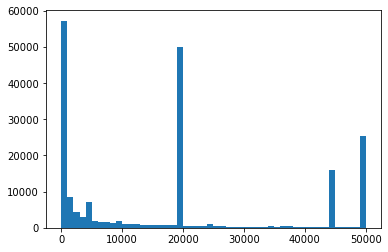

In [60]:
plt.figure()
plt.hist(cl1_ba['kd'],bins=50)
plt.show()

# netMHCIIpan 4.0 training data (cl II)

source: `https://services.healthtech.dtu.dk/suppl/immunology/NAR_NetMHCpan_NetMHCIIpan/`
        
(see also `http://tools.iedb.org/main/datasets/`)        

According to the paper, BA data taken from (19), which is Jensen et al, "Improved methods...", J Immunol 2018, which is netMHCII-2.3 and netMHCIIpan-3.2. That paper in turn says their dataset "contains peptide–MHC II
binding affinities retrieved from the IEDB `(www.iedb.org)` in 2016." It cannot be just IEDB, so it must be some other training dataset from 2016. There are no netmhcii/netmhciipan versions from 2016. In netmhciipan version history, for 3.2 they say "Method retrained on an extensive dataset of over 100,000 datapoints, covering 36 HLA-DR, 27 HLA-DQ, 9 HLA-DP, and 8 mouse MHC-II molecules". So, apparently in v.3.2 they added a lot of data, but the source of it is unclear. In fact, v.3.2 claims 134281 datapts, while in 4.0 data I find only 108362 unique pmhcs.

In [82]:
def convert_netmhc_mhc2(x):
    if x.startswith('DRB'):
        locus_b,allele_b=x.split('_')
        allele_b=allele_b[:2]+':'+allele_b[2:]
        return ('9606','DRA','01:01'),('9606',locus_b,allele_b)
    elif x.startswith('HLA'):
        _,xa,xb=x.split('-')
        locus_a,allele_a=xa[:4],xa[4:]
        locus_b,allele_b=xb[:4],xb[4:]
        allele_a=allele_a[:2]+':'+allele_a[2:]
        allele_b=allele_b[:2]+':'+allele_b[2:]
        return ('9606',locus_a,allele_a),('9606',locus_b,allele_b)
    elif x.startswith('H-2'):
        locus=x[4:6]
        allele=x[6:]
        return ('10090',locus+'A',allele),('10090',locus+'B',allele)
    else:
        return None,None

In [83]:
#cl II BA training data
cl2_ba=[]
bad_mhcs=[]
n_train=0
n_test=0
for a in ['train','test']:
    for i in range(5):
        with open(f'./data/pmhc_assays/netmhcpan_i41_ii40/NetMHCIIpan_train/{a}_BA{i+1}.txt') as f:
            s=f.read()
        for line in s.split('\n'):
            line=line.split()
            if len(line)!=4:
                print(line)
            else:
                if a=='train':
                    n_train+=1
                else:
                    n_test+=1
                pep,kd,mhc0,_=line  #drop 'context'
                mhc=convert_netmhc_mhc2(mhc0)
                if (mhc[0] in seq_tools.mhcs) and (mhc[1] in seq_tools.mhcs):
                    cl2_ba.append([pep,kd,mhc[0],mhc[1]])
                else:
                    bad_mhcs.append('_'.join(mhc[0])+'/'+'_'.join(mhc[1]))
cl2_ba=pd.DataFrame(cl2_ba,columns=['pep','log_kd','mhc_a','mhc_b'])
cl2_ba['log_kd']=pd.to_numeric(cl2_ba['log_kd'])
print('train: ',n_train,'test: ',n_test)
print('saved: ',len(cl2_ba))
print('bad_mhcs:',len(bad_mhcs))

#count and remove repeats
print(cl2_ba.groupby(['pep','mhc_a','mhc_b']).apply(len).value_counts())
#every entry repeats 5 or 10 times; related to context?
df=cl2_ba.copy()
df_kd=df.groupby(['pep','mhc_a','mhc_b'])['log_kd'].mean()
df=df.drop('log_kd',axis=1).drop_duplicates()
cl2_ba=df.merge(df_kd,on=['pep','mhc_a','mhc_b'])
cl2_ba['kd']=50000**(1-cl2_ba['log_kd'])  #restore Kd from netmhc score, which is 1-log(Kd)/log(50000)
cl2_ba=cl2_ba.drop('log_kd',axis=1)
print(len(cl2_ba))

#save 
cl2_ba.to_pickle('./data/pmhc_assays/netmhcpan_i41_ii40/assays_ii.pckl')

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
train:  435836 test:  108959
saved:  544795
bad_mhcs: 0
5     107765
10       597
dtype: int64
108362


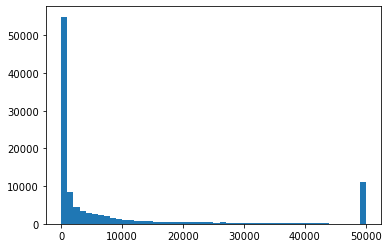

In [74]:
plt.figure()
plt.hist(cl2_ba['kd'],bins=50)
plt.show()

# contact res and mhc pseudosequences

## cl 1

In [205]:
with open('./data/pmhc_assays/netmhc_data/NetMHCpan_train/MHC_pseudo.dat') as f:
    s=f.read().split('\n')
pairings=[]
bad_mhcs=[]
for line in s:
    if len(line)>1:        
        mhc0,pseq=line.split()
        try:
            mhc=convert_netmhc_mhc1(mhc0)
            if mhc in seq_tools.mhcs:
                pairings.append([mhc,pseq])
            else:
                bad_mhcs.append(mhc0)
        except Exception as e:
            bad_mhcs.append(mhc0+' '+str(e))
print('loaded:',len(pairings))
print('bad mhcs:',len(bad_mhcs))
print(pairings[:5]) #pseq len 34

loaded: 8903
bad mhcs: 2470
[[('9913', '1', '009:01'), 'YYSMYREISENVYGSNLYLLYRDYTWEYLNYRWY'], [('9913', '1', '009:02'), 'YYSEYREISENVYESNLYLLYRDYTWEYLNYRWY'], [('9913', '1', '019:01'), 'YHTKYREISENVYGSNLYYDYDYYTWAVFNYRGY'], [('9913', '1', '020:01'), 'YHTKYREISENVYGSNLYFLYMDYTWAVFNYRGY'], [('9913', '1', '021:01'), 'YYTKYREISENVYGSNLYFQFRYYTWADFNYEGY']]


In [208]:
N_iter=1
N_pairings=1000

t0=time.time()
sets_iterations=[]
for ii in range(N_iter):
    set0=set(list(seq_tools.mhcs['9606','A','02:01'].data['pdbnum']))
    sets=[set0.copy() for x in pairings[0][1]]
    for x in np.random.permutation(pairings)[:N_pairings]:
        y=seq_tools.mhcs[x[0]].data
        sets1=[]
        for i,s in enumerate(sets):
            s1=set(list(y['pdbnum'][y['seq']==x[1][i]]))                   
            sets1.append(s&s1)
        sets=sets1
    sets_iterations.append(sets)
print('completed in ',time.time()-t0)

completed in  0.5212602615356445


In [209]:
def print_one(l):
    if len(l)>0:
        return np.random.permutation(l)[0]
    else:
        return '     '
print([print_first(list(x[0])) for x in list(zip(*sets_iterations))])

['   7 ', '   9 ', '  24 ', '  45 ', '  59 ', '  62 ', '  63 ', '  66 ', '  67 ', '  69 ', '  70 ', '  73 ', '  74 ', '  76 ', '  77 ', '  80 ', '  81 ', '  84 ', '1005 ', '1007 ', '1009 ', '1024 ', '1026 ', '1028 ', '1055 ', '1059 ', '1061A', '1063 ', '1067 ', '1069 ', '1070 ', '1073 ', '1077 ', '1081 ']


## cl 2

In [210]:
with open('./data/pmhc_assays/netmhc_data/NetMHCIIpan_train/pseudosequence.2016.all.X.dat') as f:
    s=f.read().split('\n')
pairings=[]
bad_mhcs=[]
for line in s:
    if len(line)>1:        
        mhc0,pseq=line.split()
        try:
            mhc=convert_netmhc_mhc2(mhc0)
            if (mhc[0] in seq_tools.mhcs) and (mhc[1] in seq_tools.mhcs):
                pairings.append([mhc[0],mhc[1],pseq])
            else:
                bad_mhcs.append(mhc0)
        except Exception as e:
            bad_mhcs.append(mhc0+' '+str(e))
print('loaded:',len(pairings))
print('bad mhcs:',len(bad_mhcs))

loaded: 4983
bad mhcs: 657


In [228]:
N_iter=10
N_pairings=5

data0=np.concatenate([seq_tools.mhcs['9606','DRA','01:01'].data,seq_tools.mhcs['9606','DRB1','01:01'].data])
set0=set(list(data0['pdbnum']))
t0=time.time()
sets_iterations=[]
for ii in range(N_iter):        
    sets=[set0.copy() for x in pairings[0][2]]
    for x in np.random.permutation(pairings)[:N_pairings]:
        y=np.concatenate([seq_tools.mhcs[x[0]].data,seq_tools.mhcs[x[1]].data])
        sets1=[]
        for i,s in enumerate(sets):
            s1=set(list(y['pdbnum'][y['seq']==x[2][i]]))                   
            sets1.append(s&s1)
        sets=sets1
    sets_iterations.append(sets)
print('completed in ',time.time()-t0)

completed in  0.15828299522399902


In [226]:
def print_one(l):
    if len(l)>0:
        return np.random.permutation(l)[0]
    else:
        return '     '
print([print_first(list(x[0])) for x in list(zip(*sets_iterations))])

['   7 ', '   9 ', '  24 ', '  26 ', '  33 ', '  60 ', '     ', '  66 ', '  67 ', '  69 ', '  73 ', '  74 ', '  76 ', '  80 ', '  81 ', '     ', '1007 ', '1009 ', '1022 ', '1024 ', '1026 ', '1045 ', '1055 ', '1063 ', '1066 ', '1067 ', '1070 ', '1072A', '1073 ', '1076 ', '1080 ', '1081 ', '1084 ', '1085 ']


In [229]:
for x in list(zip(*sets_iterations)):
    print(x)
    
# 7,9,24,26,33,60,??,66,67,69,73,74,76,80,81,1005?,1007,1009,1022,1024,1026,1045,1055,1063,1066,1067,1070,1072A,
# 1073,1076?,1080,1081,1084,1085

({'   7 '}, {'   7 '}, {'   7 '}, {'   7 '}, {'   7 '}, {'   7 '}, {'   7 '}, {'1026 ', '1078 ', '   7 ', '  35 ', '1028 ', '1058 ', '1012 '}, {'   7 '}, {'1078 ', '   7 ', '  35 ', '1028 ', '1058 ', '1012 '})
({'   1 ', '   9 '}, {'   9 '}, {'   9 '}, {'   9 '}, {'   9 ', '  79 '}, {'   9 '}, {'   9 '}, {'   9 '}, {'   9 ', '  79 '}, {'   9 '})
({'  10 ', '  52 ', '  28 ', '  34 ', '1036 ', '  24 ', '1014 ', '  62 ', '  26 '}, {'  24 '}, {'  24 '}, {'  24 '}, {'  24 '}, {'  24 '}, {'  24 '}, {'  24 ', '1045 '}, {'  24 '}, {'  24 '})
({'  10 ', '  52 ', '  28 ', '  34 ', '1036 ', '  24 ', '1014 ', '  62 ', '  26 '}, {'  26 '}, {'  26 '}, {'  26 '}, {'  26 '}, {'  26 '}, {'  26 '}, {'  26 '}, {'  26 '}, {'  26 '})
({'  33 '}, {'  33 '}, {'  33 '}, {'  33 '}, {'  33 '}, {'  33 '}, {'  33 '}, {'  33 '}, {'  33 '}, {'  33 '})
({'  60 '}, {'  60 '}, {'  60 '}, {'  60 '}, {'  60 '}, {'  60 '}, {'  60 '}, {'  60 '}, {'  60 '}, {'  60 '})
({'1061 ', '  61 ', '  85 ', '1038 '}, set(), {'  61 '}

## results

In [219]:
#cl 1:
#from their contact list
#['   7 ', '   9 ', '  24 ', '  45 ', '  59 ', '  62 ', '  63 ', '  66 ', '  67 ', '  69 ', '  70 ', '  73 ', '  74 ', '  76 ', '  77 ', '  80 ', '  81 ', '  84 ', '1005 ', '1007 ', '1009 ', '1024 ', '1026 ', '1028 ', '1055 ', '1059 ', '1061A', '1063 ', '1067 ', '1069 ', '1070 ', '1073 ', '1077 ', '1081 ']
#from intersection
#['   7 ', '   9 ', '  24 ', '  45 ', '  59 ', '  62 ', '  63 ', '  66 ', '  67 ', '  69 ', '  70 ', '  73 ', '  74 ', '  76 ', '  77 ', '  80 ', '  81 ', '  84 ', '1005 ', '1007 ', '1009 ', '1024 ', '1026 ', '1028 ', '1055 ', '1059 ', '1061A', '1063 ', '1067 ', '1069 ', '1070 ', '1073 ', '1077 ', '1081 ']
#['   7 ', '   9 ', '  24 ', '  45 ', '  59 ', '  62 ', '  63 ', '  66 ', '  67 ', '  69 ', '  70 ', '  73 ', '  74 ', '  76 ', '  77 ', '  80 ', '  81 ', '  84 ', '1005 ', '1007 ', '1009 ', '1024 ', '1026 ', '1028 ', '1055 ', '1059 ', '1061A', '1063 ', '1067 ', '1069 ', '1070 ', '1073 ', '1077 ', '1081 ']
#['   7 ', '   9 ', '  24 ', '  45 ', '  59 ', '  62 ', '  63 ', '  66 ', '  67 ', '  69 ', '  70 ', '  73 ', '  74 ', '  76 ', '  77 ', '  80 ', '  81 ', '  84 ', '1005 ', '1007 ', '1009 ', '1024 ', '1026 ', '1028 ', '1055 ', '1059 ', '1061A', '1063 ', '1067 ', '1069 ', '1070 ', '1073 ', '1077 ', '1081 ']
#['   7 ', '   9 ', '  24 ', '  45 ', '  59 ', '  62 ', '  63 ', '  66 ', '  67 ', '  69 ', '  70 ', '  73 ', '  74 ', '  76 ', '  77 ', '     ', '     ', '  84 ', '1005 ', '1007 ', '1009 ', '1024 ', '1026 ', '1028 ', '1055 ', '1059 ', '1061A', '1063 ', '1067 ', '1069 ', '1070 ', '1073 ', '1077 ', '1081 ']
#     x                                                    x        x                           x        x                          x                          x                        x                                   x   1058  x                   1066                     x                x         x 
#^^top contacts^^

#cl 2:
#from their contact list
#['   7 ', '   9 ', '  24 ', '  26 ', '  33 ', '  60 ', '  61 ', '  66 ', '  67 ', '  69 ', '  73 ', '  74 ', '  76 ', '  80 ', '  81 ', '1005 ', '1007 ', '1009 ', '1022 ', '1024 ', '1026 ', '1045 ', '1055 ', '1063 ', '1066 ', '1067 ', '1070 ', '1072A', '1073 ', '1076 ', '1080 ', '1081 ', '1084 ', '1085 ']
#from intersection
#['   7 ', '   9 ', '     ', '  26 ', '     ', '  60 ', '     ', '  66 ', '  67 ', '  69 ', '  73 ', '  74 ', '  76 ', '  80 ', '  81 ', '     ', '1007 ', '1009 ', '1022 ', '1024 ', '1026 ', '1045 ', '1055 ', '1063 ', '1066 ', '1067 ', '1070 ', '1072A', '1073 ', '1076 ', '1080 ', '1081 ', '1084 ', '1085 ']
#['     ', '     ', '     ', '  26 ', '     ', '  60 ', '     ', '  66 ', '  67 ', '  69 ', '  73 ', '  74 ', '  76 ', '  80 ', '  81 ', '     ', '1007 ', '1009 ', '1022 ', '1024 ', '1026 ', '1045 ', '1055 ', '1063 ', '1066 ', '1067 ', '1070 ', '1072A', '1073 ', '1076 ', '1080 ', '1081 ', '1084 ', '1085 ']
#['   7 ', '   9 ', '  24 ', '  26 ', '  33 ', '  60 ', '     ', '  66 ', '  67 ', '  69 ', '  73 ', '  74 ', '  76 ', '  80 ', '  81 ', '     ', '1007 ', '1009 ', '1022 ', '1024 ', '1026 ', '1045 ', '1055 ', '1063 ', '1066 ', '1067 ', '1070 ', '1072A', '1073 ', '   3 ', '1080 ', '1081 ', '1084 ', '1085 ']
#['   7 ', '   9 ', '  24 ', '  26 ', '  33 ', '  60 ', '     ', '  66 ', '  67 ', '  69 ', '  73 ', '  74 ', '  76 ', '  80 ', '  81 ', '     ', '1007 ', '1009 ', '1022 ', '1024 ', '1026 ', '1045 ', '1055 ', '1063 ', '1066 ', '1067 ', '1070 ', '1072A', '1073 ', '   3 ', '1080 ', '1081 ', '1084 ', '1085 ']
#consensus
#['   7 ', '   9 ', '  24 ', '  26 ', '  33 ', '  60 ', '  61 ', '  66 ', '  67 ', '  69 ', '  73 ', '  74 ', '  76 ', '  80 ', '  81 ', '1005 ', '1007 ', '1009 ', '1022 ', '1024 ', '1026 ', '1045 ', '1055 ', '1063 ', '1066 ', '1067 ', '1070 ', '1072A', '1073 ', '1076 ', '1080 ', '1081 ', '1084 ', '1085 ']
#     x                                                    x                             70    x                    77                               x       x                                             x 1058,1059                x                          x       x   1077  x                          
#^^top contacts^^
#note: numbering inconsistencies, especially for pos 61

In [141]:
#check their list for cl 1
with open('/home/vmikhayl/netMHCpan-4.1/data/all_varcontacts.nlist') as f:
    contacts1=[int(x) for x in f.read().split()]
print(len(contacts1))
contact_pdbnums=[seq_tools.mhcs['9606','B','07:02'].data['pdbnum'][i-1] for i in contacts1]
print(contact_pdbnums)

34
['   7 ', '   9 ', '  24 ', '  45 ', '  59 ', '  62 ', '  63 ', '  66 ', '  67 ', '  69 ', '  70 ', '  73 ', '  74 ', '  76 ', '  77 ', '  80 ', '  81 ', '  84 ', '1005 ', '1007 ', '1009 ', '1024 ', '1026 ', '1028 ', '1055 ', '1059 ', '1061A', '1063 ', '1067 ', '1069 ', '1070 ', '1073 ', '1077 ', '1081 ']


In [144]:
#check their list for cl 2
with open('/home/vmikhayl/netMHCIIpan-4.1/data/full_alpha.positions') as f:
    contacts2a=[int(x) for x in f.read().split()]
with open('/home/vmikhayl/netMHCIIpan-4.1/data/full_beta.positions') as f:
    contacts2b=[int(x) for x in f.read().split()]
print(len(contacts2a),len(contacts2b))
contact_pdbnums=[]
b_shift=4 #necessary to match intersection; indeed, their DRB1 seq has extra 4aa in the beginning
contact_pdbnums+=[seq_tools.mhcs['9606','DRA','01:01'].data['pdbnum'][i-1] for i in contacts2a]
contact_pdbnums+=[seq_tools.mhcs['9606','DRB1','01:01'].data['pdbnum'][i-1-b_shift] for i in contacts2b]
print(contact_pdbnums)

15 19
['   7 ', '   9 ', '  24 ', '  26 ', '  33 ', '  60 ', '  61 ', '  66 ', '  67 ', '  69 ', '  73 ', '  74 ', '  76 ', '  80 ', '  81 ', '1005 ', '1007 ', '1009 ', '1022 ', '1024 ', '1026 ', '1045 ', '1055 ', '1063 ', '1066 ', '1067 ', '1070 ', '1072A', '1073 ', '1076 ', '1080 ', '1081 ', '1084 ', '1085 ']


In [188]:
mhc1=seq_tools.mhcs['9606','DRA','01:01']
mhc2=seq_tools.mhcs['9606','DQA1','01:01']
#mhc2=seq_tools.mhcs['10090','IAB','d']
#print(mhc1.data['pdbnum'])
#print(mhc2.data['pdbnum'])
print(mhc1.seq())
print(mhc2.seq())

IKEEHVIIQAEFYLNPDQSGEFMFDFDGDEIFHVDMAKKETVWRLEEFGRFASFEAQGALANIAVDKANLEIMTKRSNYTPITN
IVADHVASCGVNLYQFYGPSGQYTHEFDGDEEFYVDLERKETAWRWPEFSKFGGFDPQGALRNMAVAKHNLNIMIKRYNSTAATN


In [157]:
from Bio import pairwise2
from Bio.SubsMat import MatrixInfo as matlist
blosum62=matlist.blosum62

In [191]:
y=pairwise2.align.globaldd(mhc1.seq(),mhc2.seq(),blosum62,
                               openA=-10,extendA=-10,openB=-10,extendB=-10,penalize_end_gaps=(False,False),
                               one_alignment_only=True)[0]    
print(y.seqA)
print(y.seqB)
seqBcor=''
for a,b in zip(y.seqA,y.seqB):
    if a!='-':
        seqBcor+=b
s=''
for i in contacts2a: #contacts2b:
    s+=seqBcor[i-1]   #-b_shift]
print(s)
print(''.join(mhc2.get_residues_by_pdbnums(contact_pdbnums)).replace('-',''))

IKEEHVI-IQAEFYLNPDQSGEFMFDFDGDEIFHVDMAKKETVWRLEEFGRFASFEAQGALANIAVDKANLEIMTKRSNYTPITN
IVADHVASCGVNLYQFYGPSGQYTHEFDGDEEFYVDLERKETAWRWPEFSKFGGFDPQGALRNMAVAKHNLNIMIKRYNSTAATN
GNYHEGGGARVAHIM
CNYHEGGGARVAHIM


In [187]:
for x in seq_tools.mhcs:
    if x[0]=='9606' and x[1].startswith('DQA'):
        print(x)

('9606', 'DQA1', '01:01')
('9606', 'DQA1', '01:02')
('9606', 'DQA1', '01:03')
('9606', 'DQA1', '01:04')
('9606', 'DQA1', '01:05')
('9606', 'DQA1', '01:06')
('9606', 'DQA1', '01:07Q')
('9606', 'DQA1', '01:08')
('9606', 'DQA1', '01:09')
('9606', 'DQA1', '01:10')
('9606', 'DQA1', '01:11')
('9606', 'DQA1', '01:12')
('9606', 'DQA1', '01:13')
('9606', 'DQA1', '01:14')
('9606', 'DQA1', '01:17')
('9606', 'DQA1', '01:18')
('9606', 'DQA1', '01:19')
('9606', 'DQA1', '01:20')
('9606', 'DQA1', '01:21')
('9606', 'DQA1', '01:22')
('9606', 'DQA1', '01:23')
('9606', 'DQA1', '01:24')
('9606', 'DQA1', '01:25')
('9606', 'DQA1', '01:26')
('9606', 'DQA1', '01:27')
('9606', 'DQA1', '01:28')
('9606', 'DQA1', '01:29')
('9606', 'DQA1', '01:30')
('9606', 'DQA1', '01:31')
('9606', 'DQA1', '01:32')
('9606', 'DQA1', '01:33')
('9606', 'DQA1', '01:34')
('9606', 'DQA1', '01:35')
('9606', 'DQA1', '01:36')
('9606', 'DQA1', '01:37')
('9606', 'DQA1', '01:38')
('9606', 'DQA1', '01:39')
('9606', 'DQA1', '01:41')
('9606', 'D

## choose pep contact residues

In [2]:
#compute entropies for MHC positions

def aa_entropy(aa_list):
    aa_list=np.array(aa_list)
    p=np.array([np.sum(aa_list==a) for a in np.unique(aa_list)])
    p=p/np.sum(p)
    return np.exp(-np.sum(p*np.log(p)))

#cl 1
#sample
df=seq_tools.mhcs_df
df=df[df['cl']=='I'].sample(frac=1).groupby('species_id').head(10)
print('cl 1:',len(df))
#count
resnums={}
for x in df.iterrows():
    x=x[1]
    mhc=seq_tools.mhcs[x['species_id'],x['locus'],x['allele']]
    for y in mhc.data:
        resnums.setdefault(y['pdbnum'],[]).append(y['seq'])
res_entropy_i={k:aa_entropy(v) for k,v in resnums.items()}

#cl 2
#sample
df=seq_tools.mhcs_df
df_A=df[(df['cl']=='II')&(df['chain']=='A')].sample(frac=1).groupby('species_id').head(10)
df_B=df[(df['cl']=='II')&(df['chain']=='B')].sample(frac=1).groupby('species_id').head(10)
df=pd.concat([df_A,df_B])
print('cl 2:',len(df))
#count
resnums={}
for x in df.iterrows():
    x=x[1]
    mhc=seq_tools.mhcs[x['species_id'],x['locus'],x['allele']]
    for y in mhc.data:
        resnums.setdefault(y['pdbnum'],[]).append(y['seq'])
res_entropy_ii={k:aa_entropy(v) for k,v in resnums.items()}

cl 1: 366
cl 2: 621


In [3]:
mhc_contacts=pd.read_pickle('./data/obj/pmhc_contacts_av.pckl')

In [24]:
netmhc_pseq1=['   7 ', '   9 ', '  24 ', '  45 ', '  59 ', '  62 ', '  63 ', '  66 ', '  67 ', '  69 ', '  70 ', '  73 ', '  74 ', '  76 ', '  77 ', '  80 ', '  81 ', '  84 ', '1005 ', '1007 ', '1009 ', '1024 ', '1026 ', '1028 ', '1055 ', '1059 ', '1061A', '1063 ', '1067 ', '1069 ', '1070 ', '1073 ', '1077 ', '1081 ']
netmhc_pseq2=['   7 ', '   9 ', '  24 ', '  26 ', '  33 ', '  60 ', '  61 ', '  66 ', '  67 ', '  69 ', '  73 ', '  74 ', '  76 ', '  80 ', '  81 ', '1005 ', '1007 ', '1009 ', '1022 ', '1024 ', '1026 ', '1045 ', '1055 ', '1063 ', '1066 ', '1067 ', '1070 ', '1072A', '1073 ', '1076 ', '1080 ', '1081 ', '1084 ', '1085 ']
ind=mhc_contacts['I']['res'].isin(netmhc_pseq1)
colors1=np.array(['blue','red'])[ind.values.astype(int)]
ind=mhc_contacts['II']['res'].isin(netmhc_pseq2)
colors2=np.array(['blue','red'])[ind.values.astype(int)]
print(len(netmhc_pseq1),len(netmhc_pseq2))

34 34


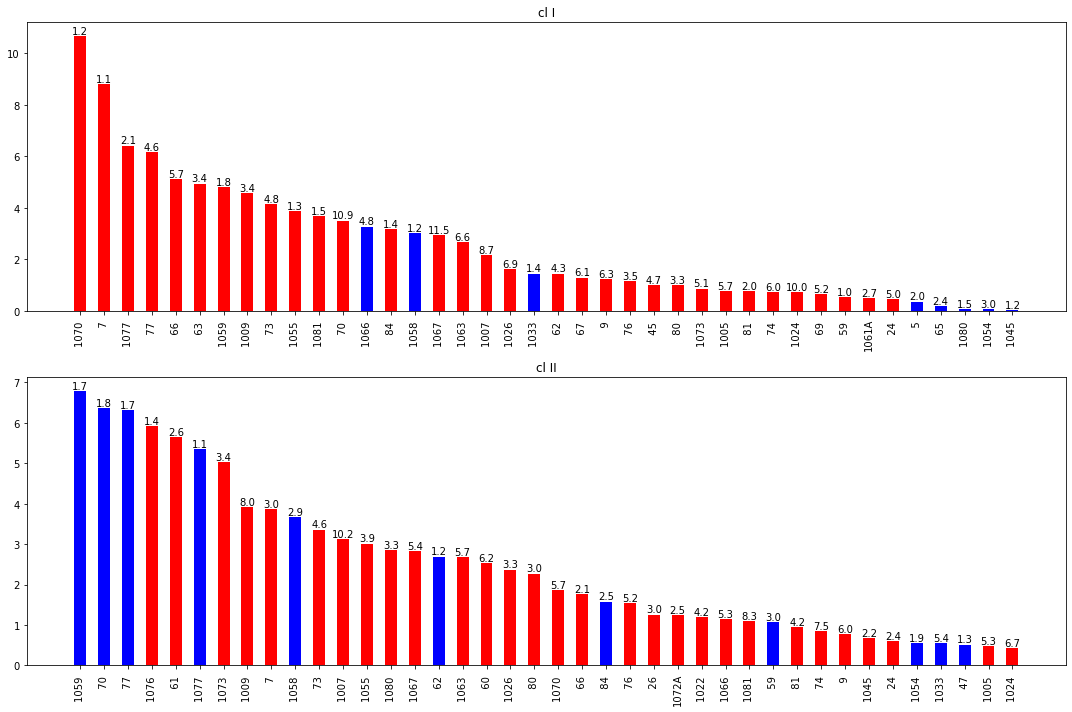

In [17]:
#contact numbers
#red -> included in netmhcpan pseudoseq, blue -> not included
n=40
#n_keep1=20
#n_keep2=25
x_space=np.arange(n)
plt.figure(figsize=(15,10))
plt.subplot(211)
df=mhc_contacts['I'].head(n)
bar1=plt.bar(np.arange(n),df['contacts'],width=0.5,color=colors1[:n])
plt.bar_label(bar1,df['res'].map({k:'{:3.1f}'.format(v) for k,v in res_entropy_i.items()}))
plt.xticks(np.arange(n),df['res'],rotation=90)
#plt.axvline(n_keep1-0.5)
plt.title('cl I')
plt.subplot(212)
df=mhc_contacts['II'].head(n)
bar2=plt.bar(np.arange(n),df['contacts'],width=0.5,color=colors2[:n])
plt.bar_label(bar2,df['res'].map({k:'{:3.1f}'.format(v) for k,v in res_entropy_ii.items()}))
plt.xticks(np.arange(n),df['res'],rotation=90)
#plt.axvline(n_keep2-0.5)
plt.title('cl II')
plt.tight_layout()
plt.show()

In [35]:
#check how polymorphic
resnum_list=['1066 ','1058 ','1033 '] #cl 1 missing
resnum_list=['1059 ','  70 ','  77 ','1077 ','1058 ','  62 ','  84 '] #cl 2 missing
resnum_list=netmhc_pseq1
#resnum_list=netmhc_pseq2


res_list=[]
for x in seq_tools.mhcs:
    if x[0]=='9606' and (x[1] in ['A','B','C']):
        mhc=seq_tools.mhcs[x]
        res=mhc.get_residues_by_pdbnums(resnum_list,show_gaps=True)
        if len(res)==len(resnum_list):
            res_list.append(res)
res_list=np.array(res_list)
for i,r in enumerate(resnum_list):
    print(r,aa_entropy([x for x in res_list[:,i] if x!='-']))    
    
#conclusion: some indeed are not polymorphic

   7  1.023285348856394
   9  4.320596786313641
  24  2.3873360098280427
  45  4.297460655331075
  59  1.0172878850667326
  62  2.5512330857379246
  63  1.8964321398661064
  66  3.0008929316830906
  67  4.7106797164053145
  69  3.033720748301068
  70  3.3822536009500754
  73  1.7831833602216611
  74  2.2961844084217464
  76  2.4185892601886545
  77  2.9225226954112284
  80  3.528087172752674
  81  1.630529002673261
  84  1.0400011014330106
1005  3.1548073430720556
1007  4.670374577689581
1009  1.8088138076810778
1024  4.474602623544526
1026  4.684101010035508
1028  1.0209801818051574
1055  1.1628158700065387
1059  1.4006739108495556
1061A 1.154500557291467
1063  3.078529649352068
1067  3.6038498439137405
1069  1.290444873805912
1070  1.0129122025309525
1073  3.173403828861726
1077  1.5315300256725934
1081  1.2701412089778015


# compare

In [18]:
#comparing two datasets
def compare_dfs(x1,x2,columns):    
    key1=x1[columns].apply(tuple,axis=1)
    key2=x2[columns].apply(tuple,axis=1)    
    ind1=key1.isin(key2.values)
    ind2=key2.isin(key1.values)
    return x1[ind1],x1[~ind1],x2[ind2],x2[~ind2]

In [19]:
#load data
#iedb assays
iedb=pd.read_pickle('./data/pmhc_assays/iedb_pmhc_assays/assays_Kd.pckl')
iedb5=pd.read_pickle('./data/pmhc_assays/iedb_pmhc_assays/assays_Kd5.pckl')
iedb_i,iedb_ii=iedb[iedb['class']=='I'],iedb[iedb['class']=='II']
iedb_i5,iedb_ii5=iedb5[iedb5['class']=='I'],iedb5[iedb5['class']=='II']
iedb_i=iedb_i.rename({'mhc_a':'mhc'},axis=1)
iedb_i5=iedb_i5.rename({'mhc_a':'mhc'},axis=1)
iedb_i=iedb_i.drop('mhc_b',axis=1)
iedb_i5=iedb_i5.drop('mhc_b',axis=1)
print('iedb pmhc Kd assays:')
print('cl I:')
print('three, five groups')
print(iedb_i.columns,iedb_i5.columns)
print(len(iedb_i),len(iedb_i5))
print('cl II:')
print('three, five groups')
print(iedb_ii.columns,iedb_ii5.columns)
print(len(iedb_ii),len(iedb_ii5))
#netmhc training data
netmhc1=pd.read_pickle('./data/pmhc_assays/netmhcpan_i41_ii40/assays_i.pckl')
print('netmhcpan 4.1:')
print(netmhc1.columns)
print(len(netmhc1))
netmhc2=pd.read_pickle('./data/pmhc_assays/netmhcpan_i41_ii40/assays_ii.pckl')
print('netmhcIIpan 4.0:')
print(netmhc2.columns)
print(len(netmhc2))
#2013 dataset
iedb_2013=pd.read_pickle('./data/pmhc_assays/iedb_i_2013/assays.pckl')
print('iedb i 2013:')
print(iedb_2013.columns)
print(len(iedb_2013))
#2009 dataset
iedb_2009=pd.read_pickle('./data/pmhc_assays/iedb_ii_2009/assays.pckl')
print('iedb ii 2009:')
print(iedb_2009.columns)
print(len(iedb_2009))

iedb pmhc Kd assays:
cl I:
three, five groups
Index(['pep', 'mhc_iedb', 'class', 'mhc', 'date', 'kd'], dtype='object') Index(['pep', 'mhc_iedb', 'class', 'mhc', 'n_mutations', 'date', 'kd'], dtype='object')
112766 124575
cl II:
three, five groups
Index(['pep', 'mhc_iedb', 'class', 'mhc_a', 'mhc_b', 'date', 'kd'], dtype='object') Index(['pep', 'mhc_iedb', 'class', 'mhc_a', 'mhc_b', 'n_mutations', 'date',
       'kd'],
      dtype='object')
36001 70478
netmhcpan 4.1:
Index(['pep', 'mhc', 'kd'], dtype='object')
198001
netmhcIIpan 4.0:
Index(['pep', 'mhc_a', 'mhc_b', 'kd'], dtype='object')
108362
iedb i 2013:
Index(['pep', 'mhc', 'kd'], dtype='object')
165196
iedb ii 2009:
Index(['pep', 'mhc_a', 'mhc_b', 'kd'], dtype='object')
45014


## cl 1

In [125]:
df=pd.concat([iedb_i5[['pep','mhc']],iedb_2013[['pep','mhc']]])
df=df.drop_duplicates()
df12,df1n2,df21,df2n1=compare_dfs(netmhc1,df,['pep','mhc'])
print(len(netmhc1),len(df))
print(len(df12),len(df1n2),len(df21),len(df2n1))

198001 173965
169581 28420 169581 4384


In [131]:
#count human and mouse assays from netmhc training set missing in my data
mhcs_missing=[]
for x in df1n2['mhc']:
    if x[0] in ['9606','10090']:
        mhcs_missing.append('_'.join(x))
print('total human and mouse:',len(mhcs_missing),'out of',len(df1n2))        
utils.print_hist(mhcs_missing)

total human and mouse: 17655 out of 28420
10090_D_b    128
10090_D_d    100
10090_K_b    111
10090_K_d    101
10090_K_k    101
10090_L_d    100
10090_L_q    100
9606_A_01:01 298
9606_A_02:01 371
9606_A_02:02 138
9606_A_02:03 147
9606_A_02:04 101
9606_A_02:05 140
9606_A_02:06 141
9606_A_02:07 101
9606_A_02:10 100
9606_A_02:11 106
9606_A_02:12 109
9606_A_02:16 107
9606_A_02:17 100
9606_A_02:19 119
9606_A_02:50 100
9606_A_03:01 269
9606_A_03:02 100
9606_A_03:19 100
9606_A_11:01 283
9606_A_11:02 100
9606_A_23:01 189
9606_A_24:02 141
9606_A_24:03 194
9606_A_25:01 100
9606_A_26:01 226
9606_A_26:02 100
9606_A_26:03 101
9606_A_29:02 224
9606_A_30:01 299
9606_A_30:02 251
9606_A_31:01 149
9606_A_32:01 100
9606_A_32:07  99
9606_A_32:15 100
9606_A_33:01 160
9606_A_66:01 272
9606_A_68:01 130
9606_A_68:02 168
9606_A_68:23 100
9606_A_69:01 122
9606_A_74:01 100
9606_A_80:01 118
9606_B_07:02 331
9606_B_08:01 264
9606_B_08:02 104
9606_B_08:03 100
9606_B_13:02 100
9606_B_14:01 100
9606_B_14:02 250
9606_B

In [132]:
#compare to iedb_i (3 groups)
df12,df1n2,df21,df2n1=compare_dfs(netmhc1,iedb_i,['pep','mhc'])
print(len(netmhc1),len(iedb_i))
print(len(df12),len(df1n2),len(df21),len(df2n1))

198001 112766
109508 88493 109508 3258


470
2021    369
2020     30
2009     23
2019     19
1997     12
2013     11
2007      2
2006      2
1991      1
1995      1
Name: date, dtype: int64
(9606, A, 02:01)    79
(9606, B, 07:02)    53
(9606, A, 03:01)    48
(9606, A, 01:01)    46
(9606, B, 44:02)    43
(9606, A, 33:03)    38
(9606, A, 24:02)    32
(9606, B, 15:01)    24
(9606, E, 01:03)    17
(9606, A, 26:01)    14
(10090, D, b)       12
(9606, B, 18:01)    11
(9606, C, 01:02)    10
(9606, E, 01:01)     9
(9606, B, 44:03)     8
(9606, B, 51:01)     7
(9606, B, 08:01)     6
(9606, B, 14:02)     6
(10090, K, b)        2
(10090, K, d)        2
(10090, K, k)        1
(9606, A, 11:01)     1
(9606, C, 07:01)     1
Name: mhc, dtype: int64


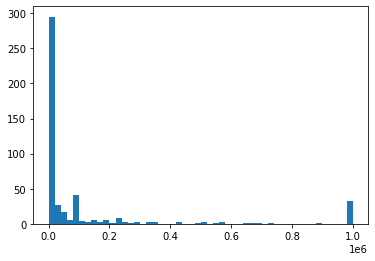

binders: 138 non-binders: 332


In [140]:
def check_sp(x):
    return x[0] in ['9606','10090']
x=df2n1[df2n1['mhc'].map(check_sp)]
print(len(x))
print(x['date'].value_counts())
print(x['mhc'].value_counts())
plt.figure()
plt.hist(x['kd'],bins=50)
plt.show()
print('binders:',np.sum(x['kd']<500),'non-binders:',np.sum(x['kd']>500))

## cl 2

In [20]:
#5 group
df=pd.concat([iedb_ii5[['pep','mhc_a','mhc_b']],iedb_2009[['pep','mhc_a','mhc_b']]])
df=df.drop_duplicates()
df12,df1n2,df21,df2n1=compare_dfs(netmhc2,df,['pep','mhc_a','mhc_b'])
print(len(netmhc2),len(df))
print(len(df12),len(df1n2),len(df21),len(df2n1))

108362 86928
62975 45387 62975 23953


In [23]:
#look at data
utils.print_hist(df1n2['pep'].map(len).values)
utils.print_hist(df2n1['pep'].map(len).values)

13  1610
14   686
15 36873
16  1656
17   869
18   688
19   426
20  2470
21   109
2      1
4      1
5      2
6      2
7     13
8     32
9     91
10   258
11   498
12   560
13   427
14   468
15 16819
16  1048
17   985
18   399
19   220
20  1151
21   476
22    82
23    45
24   130
25    37
26    39
27    22
28    16
29     9
30    11
31    40
32    10
34    20
35    10
37     6
39    25


In [151]:
#3 group
df=pd.concat([iedb_ii[['pep','mhc_a','mhc_b']],iedb_2009[['pep','mhc_a','mhc_b']]])
df=df.drop_duplicates()
df12,df1n2,df21,df2n1=compare_dfs(netmhc2,df,['pep','mhc_a','mhc_b'])
print(len(netmhc2),len(df))
print(len(df12),len(df1n2),len(df21),len(df2n1))

108362 67858
51625 56737 51625 16233


In [146]:
#compare to iedb_ii (3 groups)
df12,df1n2,df21,df2n1=compare_dfs(netmhc2,iedb_ii,['pep','mhc_a','mhc_b'])
print(len(netmhc2),len(iedb_ii))
print(len(df12),len(df1n2),len(df21),len(df2n1))

108362 36001
24963 83399 24963 11038


In [148]:
df2n1['date'].value_counts()

2014    4999
2015    1523
2011     985
2009     868
2013     405
2006     405
2021     390
1993     206
1989     202
2019     133
1991     119
1992     110
2001     108
2008      93
2020      82
2002      65
1990      47
1994      46
1998      39
2016      32
2017      27
1997      23
2004      22
1996      19
2012      16
2000      12
2005      12
1988      11
2007      10
1995       9
2010       8
1999       7
2003       3
2018       2
Name: date, dtype: int64

In [150]:
df2n1['mhc_b'].value_counts()

(9606, DQB1, 04:02)     778
(9606, DRB1, 14:54)     776
(9606, DRB1, 03:01)     634
(9606, DRB1, 07:01)     617
(9606, DRB1, 11:01)     612
(9606, DRB1, 04:04)     479
(9606, DRB1, 09:01)     478
(9606, DRB1, 01:01)     477
(9606, DRB5, 01:01)     471
(9606, DQB1, 03:03)     401
(9606, DRB3, 01:01)     400
(9606, DRB1, 04:01)     383
(9606, DRB1, 08:01)     356
(9606, DRB3, 03:01)     343
(9606, DQB1, 05:01)     326
(9606, DRB4, 01:03)     317
(9606, DRB1, 13:01)     316
(9606, DQB1, 03:02)     316
(9606, DQB1, 03:01)     314
(9606, DRB3, 02:02)     247
(9606, DRB1, 15:01)     230
(10090, IAB, d)         204
(9606, DRB1, 13:02)     182
(9606, DRB1, 08:02)     168
(9606, DRB1, 04:05)     144
(10090, IEB, d)         139
(9606, DRB4, 01:01)     130
(10090, IAB, b)         102
(10090, IAB, k)         102
(9544, DRB, W002:01)     67
(9606, DQB1, 06:02)      54
(9606, DRB1, 12:01)      50
(9606, DQB1, 06:03)      50
(10090, IEB, k)          47
(9606, DQB1, 02:01)      42
(9544, DRB1, 04:06) 

# make datasets

## cl 1

In [2]:
#iedb
iedb=pd.read_pickle('./data/pmhc_assays/iedb_pmhc_assays/assays_Kd.pckl')
iedb_i=iedb[iedb['class']=='I']
iedb_i=iedb_i.rename({'mhc_a':'mhc'},axis=1)
iedb_i=iedb_i.drop('mhc_b',axis=1)
#clip to 1-50k, to be consistent with netmhc1 training data
iedb_i.loc[iedb_i['kd']>50000.,'kd']=50000.
iedb_i.loc[iedb_i['kd']<1.,'kd']=1.
print('iedb')
print(iedb_i.columns)
print(len(iedb_i))
#iedb EC50
iedb_all=pd.read_pickle('./data/pmhc_assays/iedb_pmhc_assays/assays.pckl')
ec50=iedb_all[iedb_all['group']=='half maximal effective concentration (EC50)']
ec50_i=ec50[ec50['class']=='I']
ec50_pmhcs=ec50_i[['pep','mhc_a']].apply(tuple,axis=1).values
#netmhc training data
netmhc1=pd.read_pickle('./data/pmhc_assays/netmhcpan_i41_ii40/assays_i.pckl')
print('netmhcpan 4.1:')
print(netmhc1.columns)
print(len(netmhc1))
#exclude ec50
netmhc1_short=netmhc1[~(netmhc1[['pep','mhc']].apply(tuple,axis=1).isin(ec50_pmhcs))]
print('after ec50 excluded:',len(netmhc1_short))

iedb
Index(['pep', 'mhc_iedb', 'class', 'mhc', 'date', 'kd'], dtype='object')
112766
netmhcpan 4.1:
Index(['pep', 'mhc', 'kd'], dtype='object')
198001
after ec50 excluded: 196953


In [3]:
#train and test sets
def restrict_species(x):
    return x[0]=='9606'
#test set: IEDB, human, date>=2020, pmhc not in netmhc1 (so that netmhc test is fair)
#train: IEDB date<2020+netmhc1_short (concat, then average), test set removed (so that my alg test is fair)
ind_test=((iedb_i['date']>='2020')&
          (iedb_i['mhc'].map(restrict_species))&~
          (iedb_i[['pep','mhc']].apply(tuple,axis=1).isin(netmhc1[['pep','mhc']].apply(tuple,axis=1))))
test=iedb_i[ind_test]
train=pd.concat([netmhc1_short,iedb_i[~ind_test][['pep','mhc','kd']]]) #use netmhc1 with ec50 excluded
df=train.copy()
df['kd']=np.log(df['kd'])
df_kd=df.groupby(['pep','mhc'])['kd'].mean().reset_index()
df_kd['kd']=np.exp(df_kd['kd'])
df=df.drop(['kd'],axis=1).drop_duplicates()
train=df.merge(df_kd,on=['pep','mhc'])
print('train:',len(train),'test',len(test))
train=train[~train[['pep','mhc']].apply(tuple,axis=1).isin(test[['pep','mhc']].apply(tuple,axis=1))]
print('with test excluded:','train:',len(train),'test',len(test))

train: 199914 test 399
with test excluded: train: 199914 test 399


In [8]:
#length summary
print('train:')
print(train['pep'].map(len).value_counts().sort_index())
print('test:')
print(test['pep'].map(len).value_counts().sort_index())
#decision: cut to 8-15, to be sure

train:
6          1
7          1
8      11541
9     139966
10     38351
11      9018
12       372
13       397
14       232
15        25
16         1
17         7
21         1
23         1
Name: pep, dtype: int64
test:
8      25
9     255
10    105
11     14
Name: pep, dtype: int64


In [9]:
#restrict length: 8-15
l_min,l_max=8,15
s=train['pep'].map(len)
train=train[(s>=l_min)&(s<=l_max)]
s=test['pep'].map(len)
test=test[(s>=l_min)&(s<=l_max)]
print('after length restriction:')
print('train:',len(train),'test',len(test))

#rename mhc to mhc_a, for consistency
train=train.rename({'mhc','mhc_a'},axis=1)
test=test.rename({'mhc','mhc_a'},axis=1)

train.to_pickle('./data/pmhc_assays/train_i.pckl')
test.to_pickle('./data/pmhc_assays/test_i.pckl')

#train 199914 test 399; test excl does nothing
#train 199877 test 399

#199902, 399 (len 14->15)

after length restriction:
train: 199902 test 399


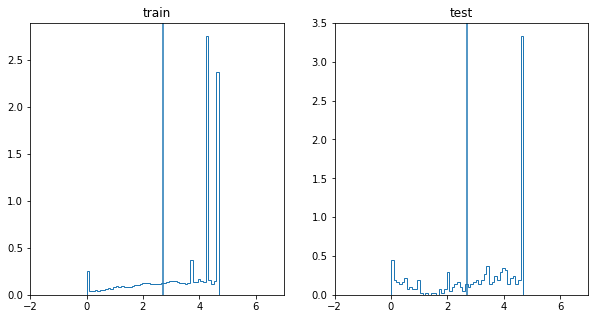

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(np.log(train['kd'])/np.log(10),bins=50,histtype='step',density=True)
plt.xlim(-2,7)
plt.axvline(np.log(500)/np.log(10))
plt.title('train')
plt.subplot(122)
plt.hist(np.log(test['kd'])/np.log(10),bins=50,histtype='step',density=True)
plt.xlim(-2,7)
plt.axvline(np.log(500)/np.log(10))
plt.title('test')
plt.show()

In [11]:
test['mhc_a'].value_counts()

(9606, A, 02:01)    55
(9606, B, 07:02)    47
(9606, A, 01:01)    46
(9606, B, 44:02)    43
(9606, A, 03:01)    39
(9606, A, 33:03)    38
(9606, A, 24:02)    32
(9606, B, 15:01)    20
(9606, A, 26:01)    14
(9606, B, 18:01)    11
(9606, C, 01:02)    10
(9606, E, 01:01)     9
(9606, B, 44:03)     8
(9606, B, 51:01)     7
(9606, B, 14:02)     6
(9606, B, 08:01)     6
(9606, E, 01:03)     6
(9606, C, 07:01)     1
(9606, A, 11:01)     1
Name: mhc, dtype: int64

## cl 2

In [12]:
#iedb
iedb=pd.read_pickle('./data/pmhc_assays/iedb_pmhc_assays/assays_Kd.pckl')
iedb_ii=iedb[iedb['class']=='II'].copy()
#clip to 1-50k, to be consistent with netmhc2 after merging
iedb_ii.loc[iedb_ii['kd']>50000.,'kd']=50000.
iedb_ii.loc[iedb_ii['kd']<1.,'kd']=1.
print('iedb')
print(iedb_ii.columns)
print(len(iedb_ii))
#iedb EC50
iedb_all=pd.read_pickle('./data/pmhc_assays/iedb_pmhc_assays/assays.pckl')
ec50=iedb_all[iedb_all['group']=='half maximal effective concentration (EC50)']
ec50_ii=ec50[ec50['class']=='II']
ec50_pmhcs=ec50_ii[['pep','mhc_a','mhc_b']].apply(tuple,axis=1).values
print('ec50:',len(ec50_pmhcs))
#netmhc training data
netmhc2=pd.read_pickle('./data/pmhc_assays/netmhcpan_i41_ii40/assays_ii.pckl')
print('netmhcpan 4.0:')
print(netmhc2.columns)
print(len(netmhc2))
#exclude ec50
netmhc2_short=netmhc2[~(netmhc2[['pep','mhc_a','mhc_b']].apply(tuple,axis=1).isin(ec50_pmhcs))]
print('after ec50 excluded:',len(netmhc2_short))
#exclude DQ4
##according to the readme in v.4.1, an error in DQ4 data was fixed;
##since don't know if the downloadable dataset was updated, better exclude DQ4
def dq4(x):
    return x[0]=='9606' and x[1].startswith('DQB1') and x[2].startswith('04')
netmhc2_short=netmhc2_short[~(netmhc2_short['mhc_b'].map(dq4))]
print('after excluding DQ4:')
print(len(netmhc2_short))    

iedb
Index(['pep', 'mhc_iedb', 'class', 'mhc_a', 'mhc_b', 'date', 'kd'], dtype='object')
36001
ec50: 345
netmhcpan 4.0:
Index(['pep', 'mhc_a', 'mhc_b', 'kd'], dtype='object')
108362
after ec50 excluded: 108249
after excluding DQ4:
104202


In [13]:
print(netmhc2['pep'].map(len).value_counts().sort_index())
print(iedb_ii['pep'].map(len).value_counts().sort_index())

13     2561
14     1182
15    92384
16     3829
17     2276
18     1488
19      627
20     3755
21      260
Name: pep, dtype: int64
2         1
4         1
6         1
7         6
8        14
9        40
10       42
11      196
12      163
13      176
14      207
15    31300
16      976
17     1358
18      389
19       76
20      591
21      414
22       11
23        9
24       16
25        9
27        3
31        2
Name: pep, dtype: int64


In [14]:
#train and test sets

#test set: IEDB, date>=2020, pmhc not in netmhc2 (so test of netmhc is fair), (all these are human)
#train: iedb<2020, netmhc2_short, with test set excluded (so test of my alg is fair)
ind_test=((iedb_ii['date']>='2020')&~
          (iedb_ii[['pep','mhc_a','mhc_b']].apply(tuple,axis=1).isin(netmhc2[['pep','mhc_a','mhc_b']].apply(tuple,axis=1))))
test=iedb_ii[ind_test]
train=pd.concat([netmhc2_short,iedb_ii[~ind_test][['pep','mhc_a','mhc_b','kd']]]) #use netmhc2_short here!
df=train.copy()
df['kd']=np.log(df['kd'])
df_kd=df.groupby(['pep','mhc_a','mhc_b'])['kd'].mean().reset_index()
df_kd['kd']=np.exp(df_kd['kd'])
df=df.drop(['kd'],axis=1).drop_duplicates()
train=df.merge(df_kd,on=['pep','mhc_a','mhc_b'])
print('train:',len(train),'test',len(test))
train=train[~train[['pep','mhc_a','mhc_b']].apply(tuple,axis=1).isin(test[['pep','mhc_a','mhc_b']].apply(tuple,axis=1))]
print('after test exclusion:','train:',len(train),'test',len(test))

train: 115865 test 472
after test exclusion: train: 115864 test 472


In [15]:
#length summary
print('train:')
print(train['pep'].map(len).value_counts().sort_index())
print('test:')
print(test['pep'].map(len).value_counts().sort_index())
#decision: cut to 9-25

train:
2         1
4         1
6         1
7         6
8        14
9        40
10       42
11      196
12      149
13     2637
14     1289
15    97797
16     4202
17     2694
18     1580
19      647
20     3907
21      611
22       11
23        9
24       16
25        9
27        3
31        2
Name: pep, dtype: int64
test:
12     14
13     17
14      2
15    334
16     14
17     14
18     58
20     19
Name: pep, dtype: int64


In [16]:
#restrict length: 9-25
l_min,l_max=9,25
s=train['pep'].map(len)
train=train[(s>=l_min)&(s<=l_max)]
s=test['pep'].map(len)
test=test[(s>=l_min)&(s<=l_max)]
print('after length restriction:')
print('train:',len(train),'test',len(test))
train.to_pickle('./data/pmhc_assays/train_ii.pckl')
test.to_pickle('./data/pmhc_assays/test_ii.pckl')

#train: 115865 test 472
#excl test -> 115864
#len resticted
#train: 115802 test 472

#len 9-25: 
#115836,472

after length restriction:
train: 115836 test 472


In [17]:
#check DQ4 still present (coming from iedb)
print(np.sum(train['mhc_b'].map(dq4).values))

1864


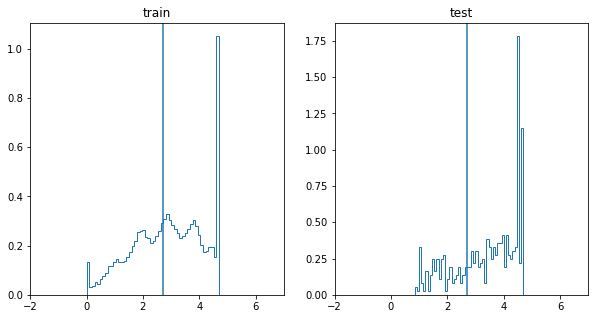

In [18]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(np.log(train['kd'])/np.log(10),bins=50,histtype='step',density=True)
plt.xlim(-2,7)
plt.axvline(np.log(500)/np.log(10))
plt.title('train')
plt.subplot(122)
plt.hist(np.log(test['kd'])/np.log(10),bins=50,histtype='step',density=True)
plt.xlim(-2,7)
plt.axvline(np.log(500)/np.log(10))
plt.title('test')
plt.show()

In [19]:
print(test['mhc_a'].value_counts())
print()
print(test['mhc_b'].value_counts())

(9606, DRA, 01:01)     429
(9606, DQA1, 05:01)     14
(9606, DQA1, 01:02)      8
(9606, DQA1, 01:01)      7
(9606, DQA1, 02:01)      7
(9606, DQA1, 03:01)      7
Name: mhc_a, dtype: int64

(9606, DRB1, 04:01)    80
(9606, DRB1, 03:01)    27
(9606, DRB1, 07:01)    27
(9606, DRB1, 11:01)    27
(9606, DRB1, 08:02)    25
(9606, DRB1, 09:01)    25
(9606, DRB1, 13:02)    25
(9606, DRB1, 04:02)    24
(9606, DRB1, 01:01)    23
(9606, DRB1, 15:01)    20
(9606, DRB3, 02:02)    18
(9606, DRB5, 01:01)    18
(9606, DRB4, 01:01)    18
(9606, DRB3, 01:01)    18
(9606, DRB1, 12:01)    18
(9606, DRB1, 04:05)    18
(9606, DQB1, 03:01)    14
(9606, DQB1, 06:02)     8
(9606, DQB1, 05:01)     7
(9606, DQB1, 02:02)     7
(9606, DQB1, 02:01)     7
(9606, DRB1, 04:04)     7
(9606, DRB1, 11:04)     7
(9606, DRB1, 08:01)     2
(9606, DRB1, 13:01)     2
Name: mhc_b, dtype: int64


# cluster and split

In [20]:
with open('./data/pmhc_assays/train_i.pckl','rb') as f:
    train_i=pickle.load(f)
print(len(train_i))
print(train_i.columns)
with open('./data/pmhc_assays/train_ii.pckl','rb') as f:
    train_ii=pickle.load(f)
print(len(train_ii))
print(train_ii.columns)
with open('./data/pmhc_assays/test_i.pckl','rb') as f:
    test_i=pickle.load(f)
print(len(test_i))
print(test_i['mhc_a'].value_counts())
with open('./data/pmhc_assays/test_ii.pckl','rb') as f:
    test_ii=pickle.load(f)
print(len(test_ii))
print(test_ii[['mhc_a','mhc_b']].apply(tuple,axis=1).value_counts())

199902
Index(['pep', 'mhc', 'kd'], dtype='object')
115836
Index(['pep', 'mhc_a', 'mhc_b', 'kd'], dtype='object')
399
(9606, A, 02:01)    55
(9606, B, 07:02)    47
(9606, A, 01:01)    46
(9606, B, 44:02)    43
(9606, A, 03:01)    39
(9606, A, 33:03)    38
(9606, A, 24:02)    32
(9606, B, 15:01)    20
(9606, A, 26:01)    14
(9606, B, 18:01)    11
(9606, C, 01:02)    10
(9606, E, 01:01)     9
(9606, B, 44:03)     8
(9606, B, 51:01)     7
(9606, B, 14:02)     6
(9606, B, 08:01)     6
(9606, E, 01:03)     6
(9606, C, 07:01)     1
(9606, A, 11:01)     1
Name: mhc, dtype: int64
472
((9606, DRA, 01:01), (9606, DRB1, 04:01))     80
((9606, DRA, 01:01), (9606, DRB1, 03:01))     27
((9606, DRA, 01:01), (9606, DRB1, 07:01))     27
((9606, DRA, 01:01), (9606, DRB1, 11:01))     27
((9606, DRA, 01:01), (9606, DRB1, 08:02))     25
((9606, DRA, 01:01), (9606, DRB1, 09:01))     25
((9606, DRA, 01:01), (9606, DRB1, 13:02))     25
((9606, DRA, 01:01), (9606, DRB1, 04:02))     24
((9606, DRA, 01:01), (9606

## cluster mhcs

### cl I

In [4]:
df=train_i

#make df with sequences aligned by pdbnum
df_mhcs=None
for x in df['mhc_a'].unique():
    y=seq_tools.mhcs[x].data
    c_df=pd.DataFrame(y['seq'],index=y['pdbnum'],columns=[x])
    if df_mhcs is None:
        df_mhcs=c_df
    else:
        df_mhcs=df_mhcs.merge(c_df,how='outer',left_index=True,right_index=True)
df_mhcs=df_mhcs.fillna('X')
print(len(df_mhcs.columns))

#make distance matrix
t0=time.time()
mhc_dist={}
for k1,k2 in itertools.combinations(df_mhcs.columns,2):
    mhc_dist[k1,k2]=len(df_mhcs)-np.sum(df_mhcs.apply((lambda x:x[k1]==x[k2]),axis=1).values)
print(f'distances computed in {time.time()-t0}')

161
distances computed in 34.720399379730225


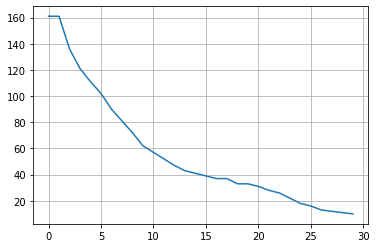

total clusters: 102


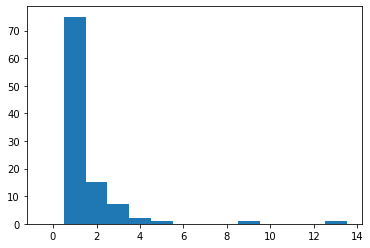

In [5]:
%matplotlib inline
col=df_mhcs.columns
dist_matrix=np.zeros((len(col),len(col))) #symmetric distance matrix
for i,x in enumerate(col):
    for j,y in enumerate(col):
        dist_matrix[i,j]=mhc_dist.get((x,y)) or mhc_dist.get((y,x)) or 0         
dist_matrix=squareform(dist_matrix)           #condensed distance matrix  
Z=cluster.hierarchy.linkage(dist_matrix,method='single')
#plot cluster number vs cutoff
sizes=[len(np.unique(cluster.hierarchy.cut_tree(Z,height=d))) for d in range(30)]
plt.figure()
plt.plot(sizes)
plt.grid()
plt.show()
#set threshold
d=5
ZZ=cluster.hierarchy.cut_tree(Z,height=d)
cluster_list=[np.nonzero(ZZ==x)[0] for x in range(len(np.unique(ZZ)))] #clusters in order id=0, id=1, ...
print('total clusters:',len(cluster_list))
#cluster length distrib
plt.figure()
plt.hist([len(x) for x in cluster_list],bins=-0.5+np.arange(15))
plt.show()

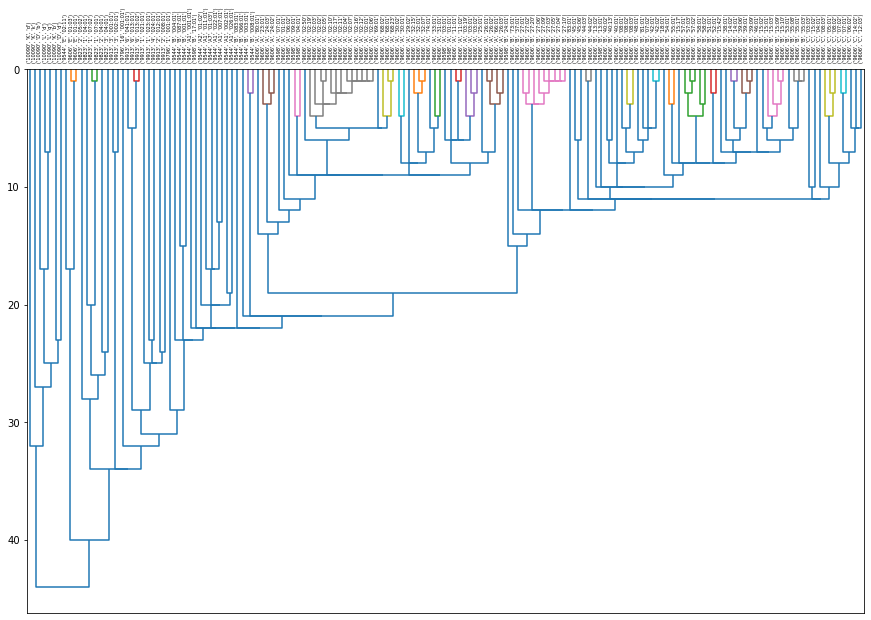

In [6]:
#%matplotlib notebook
plt.figure(figsize=(15,10))
cluster.hierarchy.dendrogram(Z,orientation='bottom',labels=col,color_threshold=d)
plt.show()

In [19]:
#save
cluster_list_mhcs=[]
for c in cluster_list:
    cluster_list_mhcs.append([df_mhcs.columns[x] for x in c])
with open('./data/pmhc_assays/train_clustered/mhc_clusters_i.pckl','wb') as f:
    pickle.dump(cluster_list_mhcs,f)

### cl II

In [25]:
mhc_ab=train_ii[['mhc_a','mhc_b']].apply(tuple,axis=1).unique()
print(len(mhc_ab))

#make df with sequences aligned by pdbnum
df_mhcs=None
for x in mhc_ab:
    y=np.concatenate([seq_tools.mhcs[x[0]].data,seq_tools.mhcs[x[1]].data])
    c_df=pd.DataFrame(y['seq'],index=y['pdbnum'],columns=[x])
    if df_mhcs is None:
        df_mhcs=c_df
    else:
        df_mhcs=df_mhcs.merge(c_df,how='outer',left_index=True,right_index=True)
df_mhcs=df_mhcs.fillna('X')
print(len(df_mhcs.columns))

#make distance matrix
t0=time.time()
mhc_dist={}
for k1,k2 in itertools.combinations(df_mhcs.columns,2):
    mhc_dist[k1,k2]=len(df_mhcs)-np.sum(df_mhcs.apply((lambda x:x[k1]==x[k2]),axis=1).values)
print(f'distances computed in {time.time()-t0}')

83
83
distances computed in 8.707979440689087


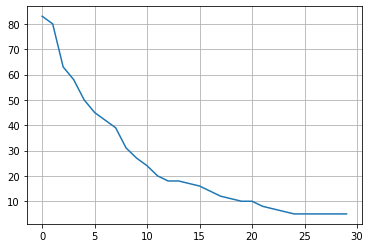

total clusters: 45


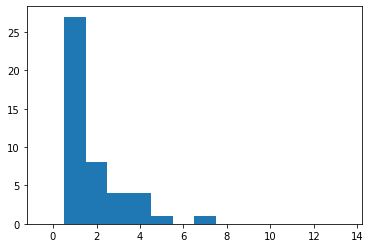

In [27]:
%matplotlib inline
col=df_mhcs.columns
dist_matrix=np.zeros((len(col),len(col))) #symmetric distance matrix
for i,x in enumerate(col):
    for j,y in enumerate(col):
        dist_matrix[i,j]=mhc_dist.get((x,y)) or mhc_dist.get((y,x)) or 0         
dist_matrix=squareform(dist_matrix)           #condensed distance matrix  
Z=cluster.hierarchy.linkage(dist_matrix,method='single')
#plot cluster number vs cutoff
sizes=[len(np.unique(cluster.hierarchy.cut_tree(Z,height=d))) for d in range(30)]
plt.figure()
plt.plot(sizes)
plt.grid()
plt.show()
#set threshold
d=5
ZZ=cluster.hierarchy.cut_tree(Z,height=d)
cluster_list=[np.nonzero(ZZ==x)[0] for x in range(len(np.unique(ZZ)))] #clusters in order id=0, id=1, ...
print('total clusters:',len(cluster_list))
#cluster length distrib
plt.figure()
plt.hist([len(x) for x in cluster_list],bins=-0.5+np.arange(15))
plt.show()

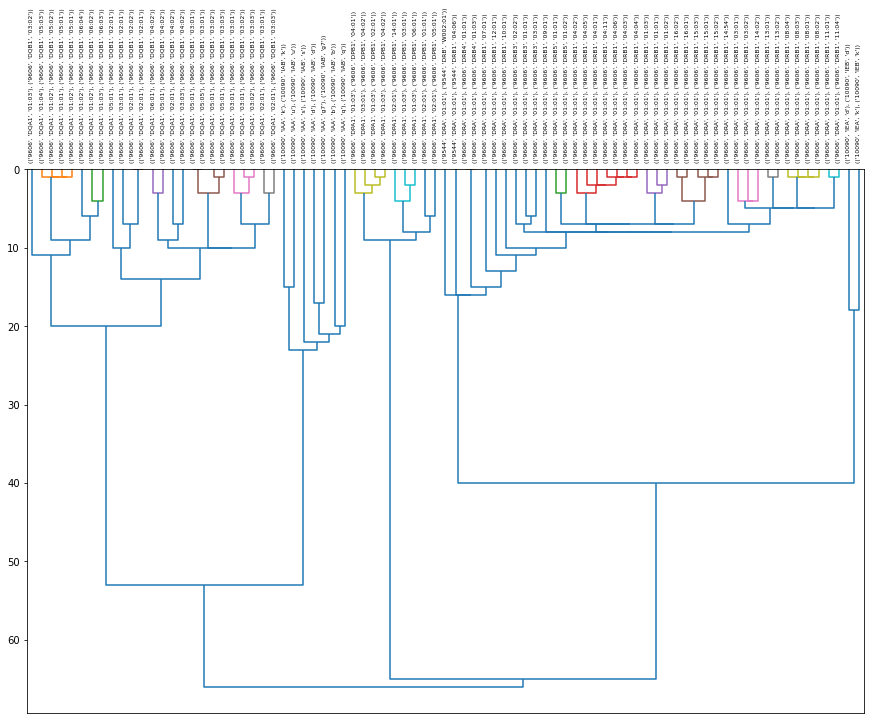

In [28]:
#%matplotlib notebook
plt.figure(figsize=(15,10))
cluster.hierarchy.dendrogram(Z,orientation='bottom',labels=col,color_threshold=d)
plt.show()

In [29]:
#save
cluster_list_mhcs=[]
for c in cluster_list:
    cluster_list_mhcs.append([df_mhcs.columns[x] for x in c])
with open('./data/pmhc_assays/train_clustered/mhc_clusters_ii.pckl','wb') as f:
    pickle.dump(cluster_list_mhcs,f)

## cluster peps

In [21]:
#load mhc clusters
with open('./data/pmhc_assays/train_clustered/mhc_clusters_i.pckl','rb') as f:
    mhc_clusters_i=pickle.load(f)
mhc_to_cluster_i={}
for i,c in enumerate(mhc_clusters_i):
    for x in c:
        mhc_to_cluster_i[x]=i
print('cl 1')
print('mhcs:',len(mhc_to_cluster_i))
print('clusters:',len(mhc_clusters_i))
with open('./data/pmhc_assays/train_clustered/mhc_clusters_ii.pckl','rb') as f:
    mhc_clusters_ii=pickle.load(f)
mhc_to_cluster_ii={}
for i,c in enumerate(mhc_clusters_ii):
    for x in c:
        mhc_to_cluster_ii[x]=i
print('cl 2')
print('mhcs:',len(mhc_to_cluster_ii))
print('clusters:',len(mhc_clusters_ii))

cl 1
mhcs: 161
clusters: 102
cl 2
mhcs: 83
clusters: 45


## cl 1

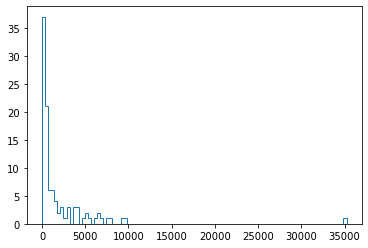

7 35233 [('9606', 'A', '02:01'), ('9606', 'A', '02:02'), ('9606', 'A', '02:03'), ('9606', 'A', '02:06'), ('9606', 'A', '02:11'), ('9606', 'A', '02:12'), ('9606', 'A', '02:16'), ('9606', 'A', '02:19'), ('9606', 'A', '02:17'), ('9606', 'A', '02:05'), ('9606', 'A', '02:07'), ('9606', 'A', '02:10'), ('9606', 'A', '02:04')]
8 9751 [('9606', 'A', '68:02'), ('9606', 'A', '68:01'), ('9606', 'A', '68:23')]
9 7840 [('9606', 'A', '03:01'), ('9606', 'A', '03:19'), ('9606', 'A', '03:02')]
10 7600 [('9606', 'A', '23:01'), ('9606', 'A', '24:03'), ('9606', 'A', '24:02')]
12 6336 [('9606', 'A', '26:01'), ('9606', 'A', '66:01'), ('9606', 'A', '26:02'), ('9606', 'A', '26:03')]
17 5532 [('9606', 'B', '27:03'), ('9606', 'B', '27:05'), ('9606', 'B', '27:20'), ('9606', 'B', '27:01'), ('9606', 'B', '27:04'), ('9606', 'B', '27:06'), ('9606', 'B', '27:02'), ('9606', 'B', '27:09'), ('9606', 'B', '27:10')]
20 6952 [('9606', 'B', '57:01'), ('9606', 'B', '58:01'), ('9606', 'B', '57:03'), ('9606', 'B', '58:02'), ('9

In [22]:
df=train_i
assay_ids=[] #indices of assays, for each mhc cluster
for c in mhc_clusters_i:
    assay_ids.append(np.nonzero(df['mhc_a'].isin(c).values)[0])     
plt.figure()
plt.hist([len(x) for x in assay_ids],bins=100,histtype='step')
plt.show()    
for i,x in enumerate(assay_ids):
    if len(x)>5000:
        print(i,len(x),mhc_clusters_i[i])

In [23]:
#peptide occurence numbers
pep_counts=train_i['pep'].value_counts()
print(len(pep_counts),len(train_i))
print('histogram:')
for n in np.sort(np.unique(pep_counts.values)):
    print(n,np.sum(pep_counts==n))

55157 199902
histogram:
1 27329
2 10740
3 2817
4 1163
5 5909
6 1925
7 525
8 359
9 185
10 199
11 416
12 129
13 142
14 93
15 110
16 261
17 322
18 224
19 174
20 169
21 121
22 132
23 179
24 230
25 150
26 175
27 212
28 98
29 57
30 138
31 62
32 50
33 32
34 59
35 20
36 31
37 21
38 73
39 34
40 19
41 7
42 4
43 4
44 4
45 1
47 1
53 19
54 15
55 9
56 5
57 2
60 1
62 1


In [24]:
#choose assays for valid sets

#use peps with exactly one assay
pep_counts=train_i['pep'].value_counts() #index: pep seq, value: number of assays
peps_good=pep_counts[pep_counts.values==1].index.values #peptides with 1 assay
assays_good=train_i[train_i['pep'].isin(peps_good)]

#choose valid assays from random mhc clusters
n_target=2500  #five sets of 500 assays
n_per_mhc=100  #max number of assays per mhc cluster
valid_df=None
for c in mhc_clusters_i:
    c_assays=assays_good[assays_good['mhc_a'].isin(c)]
    if len(c_assays)>n_per_mhc: #drop small clusters
        c_assays=c_assays.sample(frac=1)[:n_per_mhc]
        if valid_df is None:
            valid_df=c_assays
        else:
            valid_df=pd.concat([valid_df,c_assays])
        if len(valid_df)>=n_target:
            break
print(len(valid_df))
print(valid_df['mhc_a'].value_counts())

#save valid assays, valid and other peptides
tmp_dir='/scratch/vmikhayl/tmp_pep_distance_split'
valid_peps=valid_df['pep'].unique()
all_peps=train_i['pep'].unique()
if True:
    valid_df.to_pickle(tmp_dir+'/valid_df_i.pckl')
    with open(tmp_dir+'/peps_i.pckl','wb') as f:
        pickle.dump({'valid':valid_peps,'all':all_peps},f)

2500
(10090, D, b)         100
(9606, A, 01:01)      100
(10090, K, b)         100
(9544, A1, 002:01)    100
(9606, B, 07:02)      100
                     ... 
(9606, A, 02:10)        1
(9606, A, 02:12)        1
(9606, A, 02:06)        1
(9606, A, 02:02)        1
(9606, A, 02:07)        1
Name: mhc, Length: 67, dtype: int64


In [25]:
#make script for computing distances
#note: currently the script is written for 2500 valid peps, 100 jobs with 25 peps per job

#SWITCH CL I and CL II IN THE SCRIPT BEFORE RUNNING!

n_tasks=100 #do not change without updating the script!
log_dir_server=tmp_dir+'/logs'
qos='short'
max_run_time=5*60 #5 hrs
python_path='/data/vmikhayl/tfold/scripts/compute_pep_distances.py'

lines=[]
lines.append('#!/bin/bash')
lines.append('')       
lines.append(f'#SBATCH --array=0-{n_tasks-1}')             #run an array of n_tasks tasks
lines.append(f'#SBATCH --output={log_dir_server}/output_%a.txt')  #here %a will evaluate to array task id
lines.append(f'#SBATCH --error={log_dir_server}/error_%a.txt')
lines.append(f'#SBATCH --ntasks=1')                        #each array element is one task
lines.append(f'#SBATCH --cpus-per-task=1')                 #one cpu per task
lines.append(f'#SBATCH --qos={qos}')  
lines.append(f'#SBATCH --time={max_run_time}')             #maximal run time in minutes, same for each array task
lines.append('')
lines.append(f'srun python {python_path} $SLURM_ARRAY_TASK_ID')
script_filename='pep_distances.sh'
with open('./scripts/'+script_filename,'w') as f:
    f.writelines('\n'.join(lines))
os.chmod('./scripts/'+script_filename, stat.S_IRWXU | stat.S_IXGRP | stat.S_IXOTH)

In [27]:
#parse results, split valid
valid_df=pd.read_pickle(tmp_dir+'/valid_df_i.pckl')
print(len(valid_df))
with open(tmp_dir+'/peps_i.pckl','rb') as f:
    peps=pickle.load(f)
print(peps.keys())

#restore which clusters were used
c_used=[]
for c in mhc_clusters_i:
    if np.sum(valid_df['mhc_a'].isin(c))>0:
        c_used.append(c)
print('mhc clusters used in valid:',len(c_used))

n_sets=5
threshold=3
train_valid_split=[]
c_ind=np.random.permutation(len(c_used))

for i in range(n_sets):
    cc=[x for j in c_ind[5*i:5*(i+1)] for x in c_used[j]]
    c_valid=valid_df[valid_df['mhc_a'].isin(cc).copy()]    
    pep_exclude=set()
    for j in range(100):        
        ind_pep=np.nonzero(np.isin(peps['valid'][25*j:25*(j+1)],c_valid['pep']))[0]
        if len(ind_pep)>0:
            d=np.load(tmp_dir+f'/outputs_i/d_{j}.pckl.npy')
            d=np.min(d[:,ind_pep],axis=1)
            pep_exclude|=set(list(peps['all'][d<=threshold]))
    c_train=train_i[~train_i['pep'].isin(pep_exclude)]
    c_train.to_pickle(f'./data/pmhc_assays/train_clustered/split_i/train_{i}.pckl')
    c_valid.to_pickle(f'./data/pmhc_assays/train_clustered/split_i/valid_{i}.pckl')
    print(i,'pep excluded:',len(pep_exclude),'assays excluded:',len(train_i)-len(c_train))    

2500
dict_keys(['valid', 'all'])
mhc clusters used in valid: 25
0 pep excluded: 1246 assays excluded: 2659
1 pep excluded: 1259 assays excluded: 2347
2 pep excluded: 1242 assays excluded: 2816
3 pep excluded: 1550 assays excluded: 3074
4 pep excluded: 1474 assays excluded: 3038


In [28]:
#test split
from multiprocessing import Pool
from Bio import pairwise2

split_n=3
c_train=pd.read_pickle(f'./data/pmhc_assays/train_clustered/split_i/train_{split_n}.pckl').reset_index()
c_valid=pd.read_pickle(f'./data/pmhc_assays/train_clustered/split_i/valid_{split_n}.pckl').reset_index()
print(len(c_train),len(c_valid))

def dij_func(x):
    i,j=x
    seq1,seq2=c_train['pep'].iloc[i],c_valid['pep'].iloc[j]
    y=pairwise2.align.globalms(seq1,seq2,match=1,mismatch=-1,open=-1,extend=-1)
    return np.min([(x[4]-x[3]-x[2])//2 for x in y])
def _get_distances(ind1,ind2):
    ind_pairs=list(itertools.product(ind1,ind2))       
    p=Pool(n_processes)
    with p:
        d=p.map(dij_func,ind_pairs)
    return np.array(d).reshape((len(ind1),len(ind2)))    

n_processes=25
n_valid=10
t0=time.time()
ind_valid=np.random.permutation(len(c_valid))[:n_valid]
d=_get_distances(np.arange(len(c_train)),ind_valid)
print('distances computed in {}'.format(time.time()-t0))

for i in range(n_valid):
    d_i=d[:,i]
    d_min=np.min(d_i)
    print(i,d_min,np.sum(d_i==d_min))        
    print(c_valid.iloc[ind_valid[i]],c_train.iloc[np.argmin(d_i)])    

196828 500
distances computed in 79.58684086799622
0 4.0 2
index              156488
pep            KKITGEELRY
mhc      (9598, A, 04:01)
kd           44872.503932
Name: 417, dtype: object index               15198
pep             KQITNELNY
mhc      (9606, A, 30:02)
kd               9.989993
Name: 14854, dtype: object
1 5.0 35
index               37089
pep            FHKATEAYNE
mhc      (9598, A, 09:01)
kd           44872.503932
Name: 475, dtype: object index                 996
pep             AKATGRYNL
mhc      (9606, A, 01:01)
kd           20000.004962
Name: 962, dtype: object
2 4.0 40
index              114829
pep             AAPLLVALG
mhc      (9606, B, 52:01)
kd           44872.503932
Name: 178, dtype: object index                 178
pep              AAPPVAPA
mhc      (9606, A, 02:01)
kd            4999.989042
Name: 176, dtype: object
3 4.0 105
index              120057
pep             ASVSFGLYY
mhc      (9606, A, 03:01)
kd           20000.009924
Name: 82, dtype: object index    

## cl 2

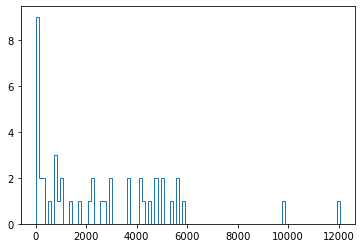

0 5609 [(('9606', 'DPA1', '01:03'), ('9606', 'DPB1', '02:01')), (('9606', 'DPA1', '01:03'), ('9606', 'DPB1', '04:01')), (('9606', 'DPA1', '01:03'), ('9606', 'DPB1', '04:02')), (('9606', 'DPA1', '03:01'), ('9606', 'DPB1', '04:02'))]
12 9796 [(('9606', 'DRA', '01:01'), ('9606', 'DRB1', '01:01')), (('9606', 'DRA', '01:01'), ('9606', 'DRB1', '01:03')), (('9606', 'DRA', '01:01'), ('9606', 'DRB1', '01:02'))]
14 12059 [(('9606', 'DRA', '01:01'), ('9606', 'DRB1', '04:01')), (('9606', 'DRA', '01:01'), ('9606', 'DRB1', '04:03')), (('9606', 'DRA', '01:01'), ('9606', 'DRB1', '04:04')), (('9606', 'DRA', '01:01'), ('9606', 'DRB1', '04:05')), (('9606', 'DRA', '01:01'), ('9606', 'DRB1', '04:02')), (('9606', 'DRA', '01:01'), ('9606', 'DRB1', '04:06')), (('9606', 'DRA', '01:01'), ('9606', 'DRB1', '04:11'))]
15 5552 [(('9606', 'DRA', '01:01'), ('9606', 'DRB1', '07:01'))]
19 5351 [(('9606', 'DRA', '01:01'), ('9606', 'DRB1', '11:01')), (('9606', 'DRA', '01:01'), ('9606', 'DRB1', '11:04'))]
22 5818 [(('9606

In [29]:
df=train_ii
assay_ids=[] #indices of assays, for each mhc cluster
for c in mhc_clusters_ii:
    assay_ids.append(np.nonzero(df[['mhc_a','mhc_b']].apply(tuple,axis=1).isin(c).values)[0])     
plt.figure()
plt.hist([len(x) for x in assay_ids],bins=100,histtype='step')
plt.show()    
for i,x in enumerate(assay_ids):
    if len(x)>5000:
        print(i,len(x),mhc_clusters_ii[i])

In [30]:
#peptide occurence numbers
pep_counts=train_ii['pep'].value_counts()
print(len(pep_counts),len(train_ii))
print('histogram:')
for n in np.sort(np.unique(pep_counts.values)):
    print(n,np.sum(pep_counts==n))

15312 115836
histogram:
1 7252
2 867
3 640
4 469
5 462
6 68
7 304
8 126
9 245
10 247
11 358
12 144
13 565
14 543
15 561
16 94
17 125
18 129
19 133
20 102
21 75
22 229
23 44
24 66
25 247
26 116
27 31
28 5
29 51
30 187
31 273
32 421
33 42
34 11
35 71
36 6
37 1
40 2


In [31]:
#choose assays for valid sets

#use peps with exactly one assay
pep_counts=train_ii['pep'].value_counts() #index: pep seq, value: number of assays
peps_good=pep_counts[pep_counts.values==1].index.values #peptides with 1 assay
assays_good=train_ii[train_ii['pep'].isin(peps_good)]

#choose valid assays from random mhc clusters
n_target=2000  #five sets of 500 assays
n_per_mhc=200  #max number of assays per mhc cluster
valid_df=None
for c in mhc_clusters_ii:
    c_assays=assays_good[assays_good[['mhc_a','mhc_b']].apply(tuple,axis=1).isin(c)]
    if len(c_assays)>25: #len(c_assays)>n_per_mhc: #drop small clusters
        c_assays=c_assays.sample(frac=1)[:n_per_mhc]
        if valid_df is None:
            valid_df=c_assays
        else:
            valid_df=pd.concat([valid_df,c_assays])
        if len(valid_df)>=n_target:
            break
print(len(valid_df))
valid_df=valid_df[:n_target] #cut
print(len(valid_df))
print(valid_df[['mhc_a','mhc_b']].apply(tuple,axis=1).value_counts())

#save valid assays, valid and other peptides
tmp_dir='/scratch/vmikhayl/tmp_pep_distance_split'
valid_peps=valid_df['pep'].unique()
all_peps=train_ii['pep'].unique()
if True:
    valid_df.to_pickle(tmp_dir+'/valid_df_ii.pckl')
    with open(tmp_dir+'/peps_ii.pckl','wb') as f:
        pickle.dump({'valid':valid_peps,'all':all_peps},f)

2009
2000
((10090, IAA, d), (10090, IAB, d))            200
((9606, DRA, 01:01), (9606, DRB1, 03:01))     200
((10090, IAA, b), (10090, IAB, b))            200
((9606, DRA, 01:01), (9606, DRB1, 01:01))     199
((9606, DRA, 01:01), (9606, DRB1, 04:01))     185
((9606, DRA, 01:01), (9606, DRB1, 07:01))     117
((9606, DRA, 01:01), (9606, DRB1, 15:01))     111
((9606, DRA, 01:01), (9606, DRB1, 11:01))     108
((9606, DRA, 01:01), (9606, DRB1, 13:02))      94
((9606, DRA, 01:01), (9606, DRB1, 08:02))      91
((9606, DQA1, 05:01), (9606, DQB1, 03:01))     80
((10090, IAA, s), (10090, IAB, s))             79
((9606, DQA1, 03:01), (9606, DQB1, 03:02))     49
((9606, DQA1, 05:01), (9606, DQB1, 02:01))     45
((9544, DRA, 01:01), (9544, DRB, W002:01))     42
((10090, IAA, u), (10090, IAB, u))             37
((9606, DRA, 01:01), (9606, DRB5, 01:01))      31
((10090, IEA, k), (10090, IEB, k))             31
((10090, IEA, d), (10090, IEB, d))             28
((9606, DQA1, 01:02), (9606, DQB1, 06:02

In [32]:
#make script for computing distances
#note: currently the script is written for 2500 valid peps, 100 jobs with 25 peps per job

n_tasks=100 #do not change without updating the script!
log_dir_server=tmp_dir+'/logs'
qos='short'
max_run_time=5*60 #5 hrs
python_path='/data/vmikhayl/tfold/scripts/compute_pep_distances.py'

lines=[]
lines.append('#!/bin/bash')
lines.append('')       
lines.append(f'#SBATCH --array=0-{n_tasks-1}')             #run an array of n_tasks tasks
lines.append(f'#SBATCH --output={log_dir_server}/output_%a.txt')  #here %a will evaluate to array task id
lines.append(f'#SBATCH --error={log_dir_server}/error_%a.txt')
lines.append(f'#SBATCH --ntasks=1')                        #each array element is one task
lines.append(f'#SBATCH --cpus-per-task=1')                 #one cpu per task
lines.append(f'#SBATCH --qos={qos}')  
lines.append(f'#SBATCH --time={max_run_time}')             #maximal run time in minutes, same for each array task
lines.append('')
lines.append(f'srun python {python_path} $SLURM_ARRAY_TASK_ID')
script_filename='pep_distances.sh'
with open('./scripts/'+script_filename,'w') as f:
    f.writelines('\n'.join(lines))
os.chmod('./scripts/'+script_filename, stat.S_IRWXU | stat.S_IXGRP | stat.S_IXOTH)

In [33]:
#parse results, split valid
valid_df=pd.read_pickle(tmp_dir+'/valid_df_ii.pckl')
print(len(valid_df))
with open(tmp_dir+'/peps_ii.pckl','rb') as f:
    peps=pickle.load(f)
print(peps.keys())

#restore which clusters were used
c_used=[]
for c in mhc_clusters_ii:
    if np.sum(valid_df[['mhc_a','mhc_b']].apply(tuple,axis=1).isin(c))>0:
        c_used.append(c)
print('mhc clusters used in valid:',len(c_used))

n_sets=4
threshold=3
train_valid_split=[]
c_ind=np.random.permutation(len(c_used))

for i in range(n_sets):
    cc=[x for j in c_ind[5*i:5*(i+1)] for x in c_used[j]]
    c_valid=valid_df[valid_df[['mhc_a','mhc_b']].apply(tuple,axis=1).isin(cc).copy()]    
    pep_exclude=set()
    for j in range(100):        
        ind_pep=np.nonzero(np.isin(peps['valid'][20*j:20*(j+1)],c_valid['pep']))[0]
        if len(ind_pep)>0:
            d=np.load(tmp_dir+f'/outputs_ii/d_{j}.pckl.npy')
            d=np.min(d[:,ind_pep],axis=1)
            pep_exclude|=set(list(peps['all'][d<=threshold]))
    c_train=train_ii[~train_ii['pep'].isin(pep_exclude)]
    c_train.to_pickle(f'./data/pmhc_assays/train_clustered/split_ii/train_{i}.pckl')
    c_valid.to_pickle(f'./data/pmhc_assays/train_clustered/split_ii/valid_{i}.pckl')
    print(i,'pep excluded:',len(pep_exclude),'assays excluded:',len(train_ii)-len(c_train),'valid:',len(c_valid))

2000
dict_keys(['valid', 'all'])
mhc clusters used in valid: 20
0 pep excluded: 723 assays excluded: 1225 valid: 569
1 pep excluded: 750 assays excluded: 2260 valid: 343
2 pep excluded: 814 assays excluded: 1610 valid: 610
3 pep excluded: 668 assays excluded: 1073 valid: 478


In [34]:
#test split
from multiprocessing import Pool
from Bio import pairwise2

split_n=3
c_train=pd.read_pickle(f'./data/pmhc_assays/train_clustered/split_ii/train_{split_n}.pckl').reset_index()
c_valid=pd.read_pickle(f'./data/pmhc_assays/train_clustered/split_ii/valid_{split_n}.pckl').reset_index()
print(len(c_train),len(c_valid))

def dij_func(x):
    i,j=x
    seq1,seq2=c_train['pep'].iloc[i],c_valid['pep'].iloc[j]
    y=pairwise2.align.globalms(seq1,seq2,match=1,mismatch=-1,open=-1,extend=-1)
    return np.min([(x[4]-x[3]-x[2])//2 for x in y])
def _get_distances(ind1,ind2):
    ind_pairs=list(itertools.product(ind1,ind2))       
    p=Pool(n_processes)
    with p:
        d=p.map(dij_func,ind_pairs)
    return np.array(d).reshape((len(ind1),len(ind2)))    

n_processes=25
n_valid=10
t0=time.time()
ind_valid=np.random.permutation(len(c_valid))[:n_valid]
d=_get_distances(np.arange(len(c_train)),ind_valid)
print('distances computed in {}'.format(time.time()-t0))

for i in range(n_valid):
    d_i=d[:,i]
    d_min=np.min(d_i)
    print(i,d_min,np.sum(d_i==d_min))        
    print(c_valid.iloc[ind_valid[i]],c_train.iloc[np.argmin(d_i)])

114763 478
distances computed in 201.8802285194397
0 9.0 3
index                  89400
pep          LDECLHLLRTDSIFK
mhc_a     (9606, DRA, 01:01)
mhc_b    (9606, DRB1, 01:01)
kd                 38.404022
Name: 87, dtype: object index                   1135
pep          FLDLVLLNLLCDLFK
mhc_a     (9606, DRA, 01:01)
mhc_b    (9606, DRB1, 01:01)
kd               1434.624003
Name: 1134, dtype: object
1 9.0 31
index                  22075
pep          MVTQMKSLVTKPFRM
mhc_a     (9606, DRA, 01:01)
mhc_b    (9606, DRB1, 01:01)
kd                  5.299712
Name: 198, dtype: object index              42357
pep      MDKRMKSLAMTAFFG
mhc_a    (10090, IAA, b)
mhc_b    (10090, IAB, b)
kd           1670.269658
Name: 41975, dtype: object
2 7.0 9
index                  79425
pep          FQRVLIFILLTAVAP
mhc_a     (9606, DRA, 01:01)
mhc_b    (9606, DRB1, 07:01)
kd               9812.630581
Name: 253, dtype: object index                  12531
pep          TQKVVIFVLLMLVTP
mhc_a     (9606, DRA, 01:01)
mhc_b

# run netmhc

In [35]:
train_i=pd.read_pickle('./data/pmhc_assays/train_i.pckl')
print('train I:',len(train_i))
train_ii=pd.read_pickle('./data/pmhc_assays/train_ii.pckl')
print('train II:',len(train_ii))
test_i=pd.read_pickle('./data/pmhc_assays/test_i.pckl')
print('test I:',len(test_i))
test_ii=pd.read_pickle('./data/pmhc_assays/test_ii.pckl')
print('test II:',len(test_ii))

train I: 199902
train II: 115836
test I: 399
test II: 472


In [38]:
train_i=train_i.rename({'mhc':'mhc_a'},axis=1)
test_i=test_i.rename({'mhc':'mhc_a'},axis=1)

In [45]:
df=test_ii
tmp_dir='/scratch/vmikhayl/tmp_netmhc' 

netmhc=netmhc_tools.NETMHC(tmp_dir)
netmhc.make_query(df,cl='II')

pmhcs with alleles known to netMHC: 472
pmhcs with alleles not known to netMHC: 0
alleles not known:
[]


In [46]:
df=netmhc.parse()
df.to_pickle('./data/pmhc_assays/netmhc_predictions/test_ii.pckl')

pmhcs expected: 472; loaded: 472


# estimate experimental kd error

In [3]:
iedb=pd.read_pickle('./data/pmhc_assays/iedb_pmhc_assays/assays.pckl')
print(len(iedb))
print(iedb.columns)

2179615
Index(['pep', 'mhc_iedb', 'class', 'mhc_a', 'mhc_b', 'n_mutations', 'date',
       'method', 'group', 'qual', 'units', 'quant_ineq', 'quant_value'],
      dtype='object')


In [4]:
#restrict group, remove ineqs, remove nan
df=iedb[iedb['group'].isin(['dissociation constant KD (~EC50)', 'dissociation constant KD (~IC50)','dissociation constant KD'])]
print(len(df))
df=df[df['quant_ineq'].isin(['','='])] 
df=df[~df['quant_value'].isna()]                        
print(len(df))
#aggregate kds
def aggregate_kds(x):
    x=np.round(x.values,0)  
    x+=0.5*(x==0)           #cutoff at 0.5
    return tuple(list(np.unique(x))[:2]) #"unique" to remove duplicates; e.g. Sidney dataset includes assays from papers
kds=df.groupby(['pep','mhc_iedb'])['quant_value'].apply(aggregate_kds).reset_index()
df=df[['pep','mhc_iedb','class','mhc_a','mhc_b']].groupby(['pep','mhc_iedb']).head(1).reset_index() #reduce to unique
df=df.merge(kds,on=['pep','mhc_iedb'])
#restrict to >=2 kds
df=df[df['quant_value'].map(lambda x: len(x)>1)]
#pick random pairs
def pick_two(x):
    return tuple([x[i] for i in np.random.permutation(len(x))[:2]])
df['quant_value']=df['quant_value'].map(pick_two)
df[['kd1','kd2']]=pd.DataFrame(df['quant_value'].tolist(), index=df.index)
df=df.drop(['index','quant_value'],axis=1)
print(len(df))

162024
110379
1735


In [5]:
#save
df.to_pickle('./data/pmhc_assays/iedb_pmhc_assays/kd_pairs.pckl')

In [6]:
df.columns

Index(['pep', 'mhc_iedb', 'class', 'mhc_a', 'mhc_b', 'kd1', 'kd2'], dtype='object')

# look at netmhc immunogenicity test data

In [19]:
#load data

#test data
with open('./data/pmhc_assays/netmhcpan_i41_ii40/NetMHCpan_test/CD8_epitopes.fsa') as f:
    s=f.read().split('\n')
ttest_i=[]
for line in s:
    if line.startswith('>'):
        ttest_i.append(line[1:].split())
ttest_i=pd.DataFrame(ttest_i,columns=['pep','mhc'])
with open('./data/pmhc_assays/netmhcpan_i41_ii40/NetMHCIIpan_test/CD4_epitopes.fsa') as f:
    s=f.read().split('\n')
ttest_ii=[]
for line in s:
    if line.startswith('>'):
        ttest_ii.append(line[1:].split())
ttest_ii=pd.DataFrame(ttest_ii,columns=['pep','mhc','prot'])
print(len(ttest_i),len(ttest_ii))
print(ttest_i.head(5))
print(ttest_ii.head(5))

#train data
train_i=pd.read_pickle('./data/pmhc_assays/train_i.pckl')
train_ii=pd.read_pickle('./data/pmhc_assays/train_ii.pckl')
print(len(train_i),len(train_ii))
print(train_i.columns,train_ii.columns)

1660 917
          pep         mhc
0   AAAGAAVTV  HLA-A02:01
1   AEIEDLIFS  HLA-B40:02
2  APTQGSASSL  HLA-B07:02
3   MAMMARDTA  HLA-B07:02
4    MAREKNDL  HLA-B08:01
                    pep        mhc      prot
0  LEEELRVVGNNLKSLEVSEE  DRB1_0101  A1KYZ2.1
1  QAMKLEKDNAMDRADTLEQQ  DRB1_0301  A1KYZ2.1
2  REEAYKEQIKTLTNKLKAAE  DRB1_0401  A1KYZ2.1
3  ENQLKEARFLAEEADRKYDE  DRB5_0101  A1KYZ2.1
4  LEEELRVVGNNLKSLEVSEE  DRB5_0101  A1KYZ2.1
199877 115802
Index(['pep', 'mhc', 'kd'], dtype='object') Index(['pep', 'mhc_a', 'mhc_b', 'kd'], dtype='object')


In [27]:
#peptide overlap
pep_u_i=ttest_i['pep'].unique()
pep_u_ii=ttest_ii['pep'].unique()
print(len(pep_u_i),len(pep_u_ii))
print(np.sum(np.isin(pep_u_i,train_i['pep'].values)),np.sum(np.isin(pep_u_ii,train_ii['pep'].values)) )

1490 713
165 61


In [14]:
#compute distances...

''

# trash

In [52]:
with open('./data/pmhc_assays/iedb_pmhc_assays/assays_Kd.pckl','rb') as f:
    iedb=pickle.load(f)
iedb

,pep,mhc_iedb,class,mhc_A,mhc_B,date,quant_value
0,EVMPVSMAK,HLA-A*03:01,I,"(9606, A, 03:01)","(None, None, None)",2004,257.504864
1,EVMPVSMAK,HLA-A*11:01,I,"(9606, A, 11:01)","(None, None, None)",2004,16.864834
2,KTFPPTEPK,HLA-A*03:01,I,"(9606, A, 03:01)","(None, None, None)",2004,215.105943
3,KTFPPTEPK,HLA-A*11:01,I,"(9606, A, 11:01)","(None, None, None)",2004,136.958547
4,ATFSVPMEK,HLA-A*03:01,I,"(9606, A, 03:01)","(None, None, None)",2004,30.480188
...,...,...,...,...,...,...,...
148769,YVFPKPFNR,HLA-A*33:03,I,"(9606, A, 33:03)","(None, None, None)",2021,1.430000
148770,YVQRFHYSR,HLA-A*33:03,I,"(9606, A, 33:03)","(None, None, None)",2021,1.370000
148771,YYYYHRQYR,HLA-A*33:03,I,"(9606, A, 33:03)","(None, None, None)",2021,0.980000
148772,AVEEVSLRK,HLA-A*11:01,I,"(9606, A, 11:01)","(None, None, None)",2021,50.850000


In [54]:
iedb[iedb['pep']=='RNSRWSSPDNVKPLY']

,pep,mhc_iedb,class,mhc_A,mhc_B,date,quant_value


In [108]:
pep_pos=df_a2_pos.sample(100)['pep'].values
pep_neg=df_a2_neg.sample(100)['pep'].values
with open('./data/pmhc_assays/peptides_A2/pos.pckl','wb') as f:
    pickle.dump(pep_pos,f)
with open('./data/pmhc_assays/peptides_A2/neg.pckl','wb') as f:
    pickle.dump(pep_neg,f)

In [4]:
#read chosen peptides
with open('./data/pmhc_assays/peptides_A2/pos.pckl','rb') as f:
    pep_pos=pickle.load(f)
with open('./data/pmhc_assays/peptides_A2/neg.pckl','rb') as f:
    pep_neg=pickle.load(f)
print(len(pep_pos),len(pep_neg))
print(pep_pos[:10])

100 100
['KVGNCDETV' 'YQIEGAWRA' 'ITDWLNFTL' 'FICWHSSEI' 'LQDSVDFSL' 'YLSSWTPVV'
 'MMMMKWIISI' 'FLFWFLKSGA' 'TINCDVGYEV' 'GLVDFVKHI']


In [8]:
#prepare netmhc queries
import csv
import stat
bash_str=''
s='peptides'
filename=s+'.csv'
out_filename=s+'_out.xls'
alleles='HLA-A02:01'#','.join(['HLA-'+re.sub('\*','',x) for x in subj_hla[s]])
#added -BA: binding affinity
query_str='/home/vmikhayl/netMHCpan-4.1/netMHCpan -p '+filename+' -xls -BA -a '+alleles+' -xlsfile '+out_filename
bash_str+=(query_str+'\n')
with open('./tmp/netmhc_queries/'+filename,'w',newline='') as f:
    f_csv=csv.writer(f)
    for p in np.concatenate([pep_pos,pep_neg]):
        f_csv.writerow([p]) 
with open('./tmp/netmhc_queries/query.sh','w', newline='') as f:
    f.write(bash_str)
os.chmod('./tmp/netmhc_queries/query.sh', stat.S_IRWXU | stat.S_IXGRP | stat.S_IXOTH)

In [10]:
#parse netmhc output

s_xls=pd.read_csv('./tmp/netmhc_queries/'+s+'_out.xls',delimiter='\t',header=[0,1])
pepmhc_dict_elrank=dict()  #{('pep','mhc'): el-rank}
pepmhc_dict_Kd=dict()  #{('pep','mhc'): Kd}
for r in s_xls.iterrows():
    y=r[1]
    pep=y[( 'Unnamed: 1_level_0',  'Peptide')]
    for i in range(  (len(s_xls.columns)-5)//6  ):
        mhc=s_xls.columns[6*i+3][0]
        mhc=mhc[4]+'*'+mhc[5:] #'HLA-A03:01 -> A*03:01
        el_rank =y[( 'Unnamed: '+str(6+6*i)+'_level_0',  'EL_Rank')]
        Kd_score=y[( 'Unnamed: '+str(7+6*i)+'_level_0',  'BA-score')]
        Kd=50000**(1-Kd_score)            
        pepmhc_dict_elrank[(pep,mhc)]=el_rank
        pepmhc_dict_Kd[(pep,mhc)]=Kd

In [12]:
with open('./data/pmhc_assays/peptides_A2/Kd.pckl','wb') as f:
    pickle.dump(pepmhc_dict_Kd,f)
with open('./data/pmhc_assays/peptides_A2/elrank.pckl','wb') as f:
    pickle.dump(pepmhc_dict_elrank,f)

In [ ]:
#load iedb data
with open('./data/pmhc_assays/iedb_mhc_dict.pckl','rb') as f:
    mhcs_dict=pickle.load(f)

#df=pd.read_pickle('./data/pmhc_assays/assays_Kd.pckl')

cl=df['mhc'].map(lambda x: mhcs_dict[x][1] is None)
iedb1=df[cl].copy()
iedb2=df[~cl].copy()

def map_mhc(x,i):
    m=mhcs_dict[x][i]['info']
    return m['species'],m['locus'],m['allele']
iedb1['mhc_tuple']=iedb1['mhc'].map(lambda x: map_mhc(x,0))
iedb1['key']=iedb1[['pep','mhc_tuple']].apply(tuple,axis=1)
iedb1=iedb1[['pep','mhc','quant_value','date','key']]
iedb2['mhc_tuple_A']=iedb2['mhc'].map(lambda x: map_mhc(x,0))
iedb2['mhc_tuple_B']=iedb2['mhc'].map(lambda x: map_mhc(x,1))
iedb2['key']=iedb2[['pep','mhc_tuple_A','mhc_tuple_B']].apply(tuple,axis=1)
iedb2=iedb2[['pep','mhc','quant_value','date','key']]

print(f'I: {len(iedb1)}, II: {len(iedb2)}')
#3 groups: 112762, 36001
#5 groups: 124549, 70474

In [ ]:
#clustering speed
ns=np.arange(100,1100,100)
ts=[]
d=10
for n_vec in ns:
    v=np.random.rand(n_vec*d).reshape([n_vec,d])
    dij=np.tensordot(v,v,axes=[1,1])
    dii=np.diag(dij)
    dist_ij=np.tile(dii[:,np.newaxis],[1,len(dii)])+np.tile(dii[np.newaxis,:],[len(dii),1])-2*dij #(vi-vj)**2
    t0=time.time()
    Z=cluster.hierarchy.linkage(dist_matrix,method='single')
    ts.append(time.time()-t0)
#conclusion: for n~1000 it's super fast

## old train data splitting

In [ ]:
# cl I

n_sets=5
n_max_per_mhc=100
n_per_set=2000
n_processes=25
threshold=4

def dij_func(x):
    i,j=x
    seq1,seq2=train_i['pep'].iloc[i],train_i['pep'].iloc[j]
    y=pairwise2.align.globalms(seq1,seq2,match=1,mismatch=-1,open=-1,extend=-1)
    return np.min([(x[4]-x[3]-x[2])//2 for x in y])

def _get_distances(ind1,ind2):
    ind_pairs=list(itertools.product(ind1,ind2))        
    p=Pool(n_processes)
    with p:
        d=p.map(dij_func,ind_pairs)
    return np.array(d).reshape((len(ind1),len(ind2)))    

t0=time.time()
train_test_pairs=[]

#marks=np.ones(len(train_i))  #mark assays used
pep_counts=train_i['pep'].value_counts()
pep_column=train_i['pep'].map(pep_counts.to_dict()) #counts for each pep
marks=(pep_column==1).values.astype(int) #restrict to peps with count 1

for s in range(n_sets):        
    c_assays_test=[]
    #go over mhc clusters in random order
    ind=np.random.permutation(len(mhc_clusters_i))
    for i in ind:        
        flags_cluster=df['mhc'].isin(mhc_clusters_i[i]).values        
        ind_test=np.nonzero(flags_cluster*marks)[0]
        if len(ind_test)>=n_max_per_mhc: #don't take very small clusters
            ind_test=np.random.permutation(ind_test)[:n_max_per_mhc]
            ind_other=np.array([k for k in np.nonzero(flags_cluster)[0] if k not in ind_test])
            #compute distances            
            d=_get_distances(ind_other,ind_test)
            #see if too many need to be added
            n0=len(ind_test)
            n_move=np.sum(np.min(d,axis=1)<=threshold)        
            f=n_max_per_mhc/(n0+n_move)
            if f<1.:
                n1=round(f*n0)
                ind1=np.random.permutation(n0)[:n1]
                d=d[:,ind1]
                ind_test1=ind_test[ind1]
                ind_move1=np.delete(ind_test,ind1)
                d1=_get_distances(ind_move1,ind_test1)  
                d=np.concatenate([d,d1])
                ind_test=ind_test1.astype(int)
                ind_other=np.concatenate([ind_other,ind_move1]).astype(int)
            ind_move=ind_other[np.min(d,axis=1)<=threshold]        
            ind_test=np.concatenate([ind_test,ind_move]).astype(int)
            marks[ind_test]=0        
            c_assays_test+=list(ind_test)
            if len(c_assays_test)>=n_per_set:
                break
    c_assays_train=[k for k in range(len(train_i)) if k not in c_assays_test]
    train_test_pairs.append([c_assays_train,c_assays_test])  
print('completed in {}'.format(time.time()-t0))

#save
for i,x in enumerate(train_test_pairs):
    c_train=train_i.iloc[x[0]]
    c_valid=train_i.iloc[x[1]]
#    c_train.to_pickle(f'./data/pmhc_assays/train_clustered/split_i/train_{i}.pckl')
#    c_valid.to_pickle(f'./data/pmhc_assays/train_clustered/split_i/valid_{i}.pckl')
    print(f'split {i}:')
    print(f'train: {len(c_train)}, valid: {len(c_valid)}')    
    print(c_valid['mhc'].value_counts())
    print()    

In [ ]:
n_sets=5
n_max_per_mhc=100
n_per_set=2000
n_processes=25
threshold=4

def dij_func(x):
    i,j=x
    seq1,seq2=train_ii['pep'].iloc[i],train_ii['pep'].iloc[j]
    y=pairwise2.align.globalms(seq1,seq2,match=1,mismatch=-1,open=-1,extend=-1)
    return np.min([(x[4]-x[3]-x[2])//2 for x in y])

def _get_distances(ind1,ind2):
    ind_pairs=list(itertools.product(ind1,ind2))        
    p=Pool(n_processes)
    with p:
        d=p.map(dij_func,ind_pairs)
    return np.array(d).reshape((len(ind1),len(ind2)))    

t0=time.time()
train_test_pairs=[]
marks=np.ones(len(train_ii))  #mark assays used
for s in range(n_sets):        
    c_assays_test=[]
    #go over mhc clusters in random order
    ind=np.random.permutation(len(mhc_clusters_ii))
    for i in ind:        
        flags_cluster=df[['mhc_a','mhc_b']].apply(tuple,axis=1).isin(mhc_clusters_ii[i]).values        
        ind_test=np.nonzero(flags_cluster*marks)[0]
        if len(ind_test)>=n_max_per_mhc: #don't take very small clusters
            ind_test=np.random.permutation(ind_test)[:n_max_per_mhc]
            ind_other=np.array([k for k in np.nonzero(flags_cluster)[0] if k not in ind_test])
            #compute distances            
            d=_get_distances(ind_other,ind_test)
            #see if too many need to be added
            n0=len(ind_test)
            n_move=np.sum(np.min(d,axis=1)<=threshold)        
            f=n_max_per_mhc/(n0+n_move)
            if f<1.:
                n1=round(f*n0)
                ind1=np.random.permutation(n0)[:n1]
                d=d[:,ind1]
                ind_test1=ind_test[ind1]
                ind_move1=np.delete(ind_test,ind1)
                d1=_get_distances(ind_move1,ind_test1)  
                d=np.concatenate([d,d1])
                ind_test=ind_test1.astype(int)
                ind_other=np.concatenate([ind_other,ind_move1]).astype(int)
            ind_move=ind_other[np.min(d,axis=1)<=threshold]        
            ind_test=np.concatenate([ind_test,ind_move]).astype(int)
            marks[ind_test]=0        
            c_assays_test+=list(ind_test)
            if len(c_assays_test)>=n_per_set:
                break
    c_assays_train=[k for k in range(len(train_ii)) if k not in c_assays_test]
    train_test_pairs.append([c_assays_train,c_assays_test])  
print('completed in {}'.format(time.time()-t0))

#save
for i,x in enumerate(train_test_pairs):
    c_train=train_ii.iloc[x[0]]
    c_valid=train_ii.iloc[x[1]]
#    c_train.to_pickle(f'./data/pmhc_assays/train_clustered/split_ii/train_{i}.pckl')
#    c_valid.to_pickle(f'./data/pmhc_assays/train_clustered/split_ii/valid_{i}.pckl')
    print(f'split {i}:')
    print(f'train: {len(c_train)}, valid: {len(c_valid)}')    
    print(c_valid[['mhc_a','mhc_b']].apply(tuple,axis=1).value_counts())
    print()    
    
#completed 2500s